# Finding 'bad' tiff files in Planet Kaggle training data

In [2]:
import os, math, csv
import numpy as np
import pandas as pd
from skimage.io import imread
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from os.path import join
import cv2
import rasterio

In [155]:
#np.linspace(0.2, 100-0.2, 50)
print(cv2.__version__)
print(np.__version__)

3.1.0
1.12.1


In [59]:
jpg_folder = '/opt/data/datasets/planet_kaggle/train-jpg'
jpg_folder_test = '/opt/data/datasets/planet_kaggle/test-jpg'
tif_folder = '/opt/data/datasets/planet_kaggle/train-tif-v2'
tif_folder_test = '/opt/data/datasets/planet_kaggle/test-tif-v3/'
tags = pd.read_csv("/opt/data/datasets/planet_kaggle/train_v2.csv")

def get_tags(name):
    return tags.loc[tags['image_name']==name].iloc[0]['tags']

In [3]:
names = []

for n in os.listdir(jpg_folder):
    if n.endswith('.jpg'):
        names.append(n.replace('.jpg',''))

    

In [63]:
# These parameters controls the percentiles used in the match algorithm:
# percentiles = np.linspace(percentile_eps, 100-percentile_eps, function_resoution)
#percentile_eps = 0.5
#function_resoution = 32
percentile_eps = 0.2
function_resoution = 50

In [67]:
def load_jpg(f):
    if os.path.exists(join(jpg_folder, f + '.jpg')):
        return imread(join(jpg_folder, f + '.jpg'))
    else:
        return imread(join(jpg_folder_test, f + '.jpg'))


def load_tif(f):
    if os.path.exists(join(tif_folder, f + '.tif')):
        return imread(join(tif_folder, f + '.tif'))
    else:
        return imread(join(tif_folder_test, f + '.tif'))

def load_geotiff(f):
    if os.path.exists(join(tif_folder, f + '.tif')):
        with rasterio.open(join(tif_folder, f + '.tif')) as src:
            b, g, r, nir = src.read()
            img = np.array([r, g, b, nir])
            return img.astype(float)
    else:
         with rasterio.open(join(tif_folder_test, f + '.tif')) as src:
            b, g, r, nir = src.read()
            img = np.array([r, g, b, nir])
            return img.astype(float)

# Convert all channels, join and cast to uint8 at range [0, 255]
tif2jpg = lambda im: np.dstack([convert_channel(im, c) for c in range(3)]).clip(0,255).astype(np.uint8)

In [156]:
im_jpg = load_jpg("train_10541")
im_tif = load_tif("train_10541")

good_name = "train_10541"
bad_name = "train_10020"
gb_name = "train_9880"

def adjust_tif(im_tif, im_jpg):
    # Lineary distribute the percentiles
    percentiles = np.linspace(percentile_eps, 100-percentile_eps, function_resoution)
    
    # Calculate the percentiles for TIF and JPG, one per channel
    #x_per_channel = [np.percentile(im_tif[:,:,c].ravel(), percentiles) for c in range(3)]
    #y_per_channel = [np.percentile(im_jpg[:,:,c].ravel(), percentiles) for c in range(3)]
    x_per_channel = []
    y_per_channel = []
    for c in range(3):
        x_per_channel.append(np.percentile(im_tif[:,:,c].ravel(), percentiles))
        y_per_channel.append(np.percentile(im_jpg[:,:,c].ravel(), percentiles))
    
    # This is the main part: we use np.interp to convert intermadiate values between
    # percentiles from TIF to JPG
    convert_channel = lambda im, c: np.interp(im[:,:,c], x_per_channel[c], y_per_channel[c])
    
    # Convert all channels, join and cast to uint8 at range [0, 255]
    tif2jpg = lambda im: np.dstack([convert_channel(im, c) for c in range(3)]).clip(0,255).astype(np.uint8)
    
    # The function could stop here, but we are going to plot a few charts about its results
    return tif2jpg(im_tif[:,:,:3])

In [147]:
im_jpg[:,:,0]

array([[79, 66, 55, ..., 76, 75, 75],
       [77, 65, 56, ..., 75, 75, 74],
       [74, 64, 58, ..., 75, 74, 74],
       ..., 
       [66, 64, 63, ..., 70, 67, 63],
       [64, 61, 61, ..., 61, 58, 54],
       [59, 56, 57, ..., 55, 55, 52]], dtype=uint8)

In [69]:
def plot_image(im):
    fig = plt.figure()
    fig.set_size_inches(16, 12)
    
    #a = fig.add_subplot(1, 1, 1)
    plt.imshow(im)
    plt.show()

def plot_images(im_name, im_tif, im_jpg):
    fig = plt.figure()
    fig.set_size_inches(12, 4)
    
    
    imgs = [ ("JPG", im_jpg), ("TIF", im_tif) ]
    l = len(imgs)
    for i, (name, img) in enumerate(imgs):
        a = fig.add_subplot(1, l, i+1)
        a.set_title(name)
        plt.imshow(img)
    plt.show()
    
def plot_four(im_name, im_tif, im_jpg, proc_tif, proc_jpg):
    fig = plt.figure()
    fig.set_size_inches(8, 8)
    
    fig.suptitle("%s: %f" % (im_name, max_warp_imgs(proc_tif, proc_jpg)), size=20)
    
    # Find number of pixel differences
    diff = np.zeros(im_tif.shape)
    diff[np.ma.where(im_tif != im_jpg)] = 1
    print(diff.sum())
    
    imgs = [ ("JPG", im_jpg), ("TIF", im_tif) ]
    imgs_2 = [ ("JPG", proc_jpg), ("TIF", proc_tif) ]
    l = len(imgs)
    for i, (name, img) in enumerate(imgs):
        a = fig.add_subplot(2, 2, i+1)
        a.set_title(name)
        plt.imshow(img)
        
    for i, (name, img) in enumerate(imgs_2):
        a = fig.add_subplot(2, 2, 2+i+1)
        plt.imshow(img)
    plt.show()


In [70]:
def threshold_gray(im):
    ret, thresh = cv2.threshold(im,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    return thresh

def threshold(im):
    return threshold_gray(cv2.cvtColor(im, cv2.COLOR_BGR2GRAY))

def threshold_canny(im):
    img_blur = cv2.medianBlur(im,5)
    return cv2.adaptiveThreshold(img_blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

bff = lambda x:cv2.bilateralFilter(cv2.cvtColor(x, cv2.COLOR_BGR2GRAY),9,75,75)

def tbff(x):
    return cv2.adaptiveThreshold( \
        cv2.bilateralFilter( \
            cv2.cvtColor(x, cv2.COLOR_BGR2GRAY) \
        ,9,75,75), \
    255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)


def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)
 
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)
 
    # return the edged image
    return edged

def plot(name, fn):
    i_j, i_t = (load_jpg(name), load_tif(name))
    i_ta = adjust_tif(i_t, i_j)
    j, t = (fn(i_j), fn(i_ta))
    plot_four(name, i_ta, i_j, t, j)

In [71]:
# http://www.learnopencv.com/image-alignment-ecc-in-opencv-c-python/
def get_gradient_sobel(im):
    # Calculate the x and y gradients using Sobel operator
    grad_x = cv2.Sobel(im,cv2.CV_32F,1,0,ksize=3)
    grad_y = cv2.Sobel(im,cv2.CV_32F,0,1,ksize=3)
 
    # Combine the two gradients
    grad = cv2.addWeighted(np.absolute(grad_x), 0.5, np.absolute(grad_y), 0.5, 0)
    return grad

def get_gradient_laplacian(im):
    return cv2.Laplacian(im, cv2.CV_32F)

def find_warp(i1, i2, grad_type='sobel'):
    # Define motion model
    #warp_mode = cv2.MOTION_AFFINE
    #warp_mode = cv2.MOTION_TRANSLATION
    warp_mode = cv2.MOTION_EUCLIDEAN
    #warp_mode = cv2.MOTION_HOMOGRAPHY
    
    # Set the stopping criteria for the algorithm.
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 5000,  1e-5)
 
    # Set the warp matrix to identity.
    if warp_mode == cv2.MOTION_HOMOGRAPHY:
            warp_matrix = np.eye(3, 3, dtype=np.float32)
    else:
            warp_matrix = np.eye(2, 3, dtype=np.float32)
            
    if grad_type == 'laplacian':
        g1, g2 = (get_gradient_laplacian(i1), get_gradient_laplacian(i2))
    else:
        g1, g2 = (get_gradient_sobel(i1), get_gradient_sobel(i2))
    
    (cc, warp_matrix) = cv2.findTransformECC(g1, g2, warp_matrix, warp_mode, criteria)
    return warp_matrix

def max_warp_imgs(i1, i2):
    def calc_max_warp(w):
        v = w.dot(np.array([0,0,1]))
        #print(v)
        return abs(math.sqrt(v[0]*v[0] + v[1] * v[1]))
    try:
        w = find_warp(i1, i2)
        #print(w)
        return calc_max_warp(w)
    except Exception as err:
        print(err)
        try:
            w = find_warp(i1, i2, grad_type='laplacian')
            return calc_max_warp(w)
        except:
            # If the alignment fails, then it's probably not the same image.
            # Mark it with a noticable mark.
            return -1000   
    
def max_warp(name, fn=lambda x: cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)):
    #ij, it = (cv2.medianBlur(load_jpg(name), 3), cv2.medianBlur(load_tif(name), 3))
    ij, it = (load_jpg(name), load_tif(name))
    i1, i2 = fn(ij), fn(adjust_tif(it, ij))
    return max_warp_imgs(i1, i2)

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC



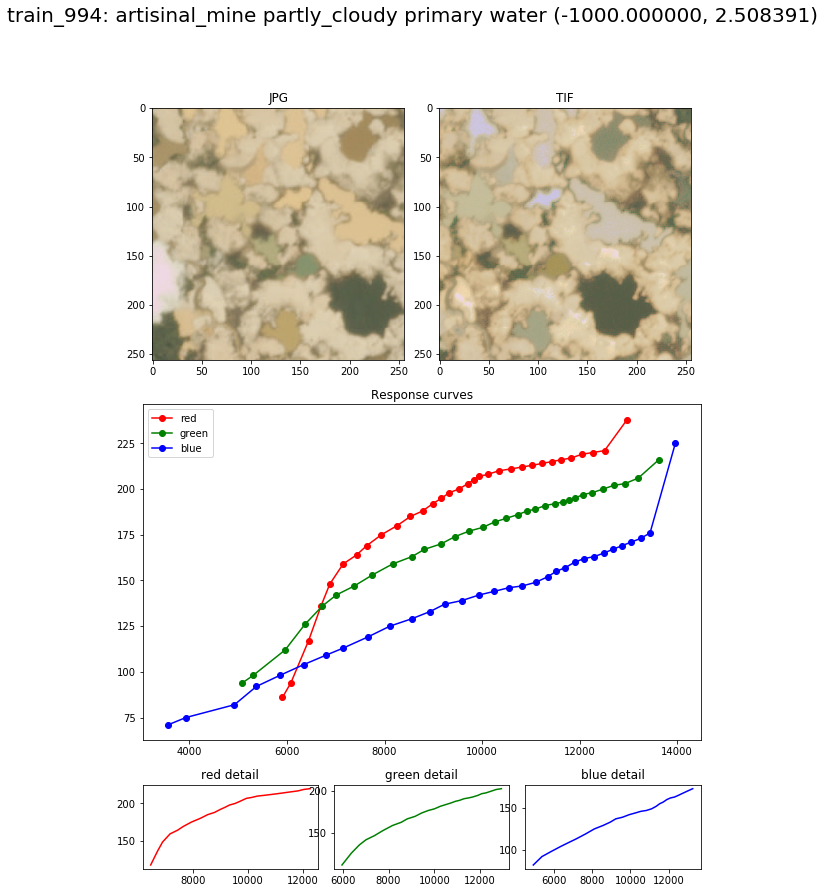

In [72]:
#f = "train_18105"
f = 'train_994'
match_percentiles(f, 
                  load_tif(f), 
                  load_jpg(f), 
                  fn=lambda x: cv2.adaptiveThreshold(cv2.bilateralFilter(cv2.cvtColor(x, cv2.COLOR_BGR2GRAY),9,75,75), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2))
plt.show()

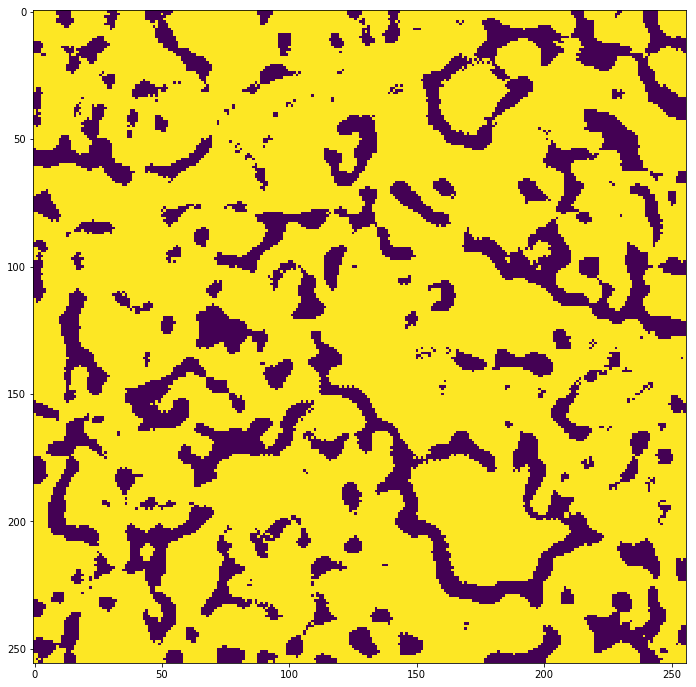

In [17]:
f = "train_994"
m = np.array([[ 0.99990356,  0.01388635,  0.75576127],
 [-0.01388635,  0.99990356, -1.48726165]])
ij, it = (load_jpg(f), load_tif(f))
i1, i2 = ij, adjust_tif(it, ij)
sz = i1.shape
im2_aligned = cv2.warpAffine(i2, m, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP);
#plot_image(im2_aligned)
plot_image(cv2.adaptiveThreshold(cv2.bilateralFilter(cv2.cvtColor(i2, cv2.COLOR_BGR2GRAY),9,75,75), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2))
#plot_image(i1[50:-50, 50:-50])

In [18]:
w = find_warp(cv2.cvtColor(im_jpg, cv2.COLOR_BGR2GRAY), cv2.cvtColor(adjust_tif(im_tif, im_jpg), cv2.COLOR_BGR2GRAY))
w.max()

1.0

In [19]:
bij, bit = (load_jpg(bad_name), load_tif(bad_name))
w = find_warp(cv2.cvtColor(bij, cv2.COLOR_BGR2GRAY), cv2.cvtColor(adjust_tif(bit, bij), cv2.COLOR_BGR2GRAY))
w.max()

8.5224838

In [ ]:
# Weird one with river 
bij, bit = (load_jpg("train_1560"), load_tif("train_1560"))
w = find_warp(cv2.cvtColor(bij, cv2.COLOR_BGR2GRAY), cv2.cvtColor(adjust_tif(bit, bij), cv2.COLOR_BGR2GRAY))
w.max()

In [ ]:
#max_warp("train_1142")
len(names) / 60 / 60

In [20]:
#plot_image(threshold(im_jpg))
#plot_image(auto_canny(im_jpg))
#plot(good_name, lambda x: threshold_gray(auto_canny(x)))
plot(good_name, lambda x: gat(cv2.medianBlur(x, 3)))

NameError: name 'gat' is not defined

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

191494.0


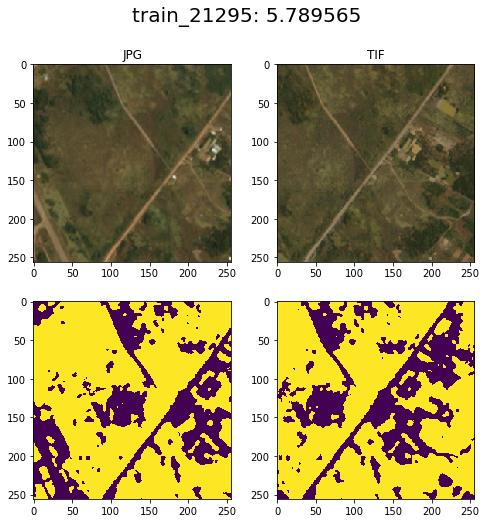

In [73]:
plot("train_21295", lambda x: threshold(cv2.medianBlur(x, 5)))
#plot(bad_name, lambda x: threshold_gray(auto_canny(x)))

171171.0


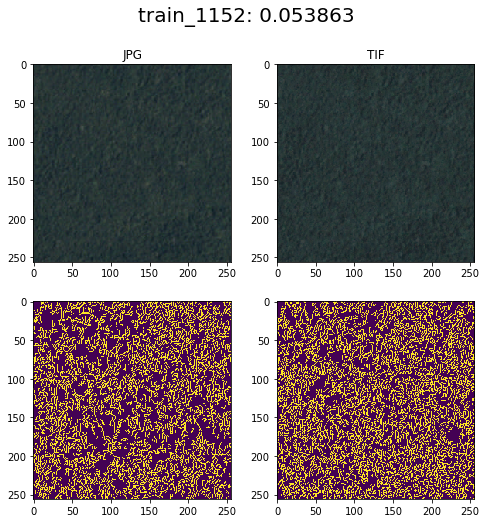

In [74]:
plot("train_1152", lambda x: auto_canny(x))

In [ ]:
#plot("train_1042", lambda x: cv2.medianBlur(threshold(cv2.medianBlur(x, 3)), 5))
plot("train_1042", lambda x: auto_canny(cv2.medianBlur(x, 3)))

In [ ]:
#plot(bad_name, lambda x: gat(cv2.medianBlur(x, 3)))
#plot(bad_name, lambda x: gg(x))
im_tif.transpose(2, 0, 1).shape

In [93]:
#plot("train_10577", lambda x: threshold(cv2.medianBlur(x, 3)))
#plot("train_9210", lambda x: threshold_canny(cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)))
def canny(im):
    b = cv2.medianBlur(im, 3)
    g = cv2.cvtColor(b, cv2.COLOR_BGR2GRAY)
    return cv2.Canny(g, 225, 250)
#plot("train_9210", canny)
#plot("train_9210", gg)


In [94]:
thresh =  lambda x: threshold(cv2.medianBlur(x, 3))
def plot_thresh(name):
    plot(name, thresh)
    

In [104]:
#plot_thresh(names[104])
def gat(im):
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    return cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
    #return cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,2)
    
def gg(im):
    return gat(cv2.medianBlur(im, 5))

def th1(im):
    return cv2.adaptiveThreshold(cv2.bilateralFilter(cv2.cvtColor(im, cv2.COLOR_BGR2GRAY),9,75,75), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

def canny1(im):
    return auto_canny(im)

func_list = [gat, 
             gg,
             th1,
             auto_canny,
             canny,
             lambda x: threshold_canny(cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)),
             #threshold_gray,
             lambda im: cv2.adaptiveThreshold(cv2.bilateralFilter(cv2.cvtColor(im, cv2.COLOR_BGR2GRAY),9,75,75), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2),
             bff,
             #lambda im: cv2.warpAffine(im, m, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP),
             tbff,
            ]

#plot(names[1220], lambda x: gg(x))
#plot(names[1220], lambda x: threshold(cv2.medianBlur(x, 5)))
#plot("train_1560", lambda x: threshold(cv2.medianBlur(x, 5)))

In [90]:
def compute_gray_norm(im_jpg, im_tif):
    #return cv2.norm(threshold(cv2.medianBlur(im_jpg, 3)), threshold(cv2.medianBlur(adjust_tif(im_tif, im_jpg), 3)))
    return cv2.norm(gg(im_jpg), gg(adjust_tif(im_tif, im_jpg)))

def compute_gray_norm_name(n):
    return compute_gray_norm(load_jpg(n), load_tif(n))

In [91]:
print(compute_gray_norm_name("train_10541"))
print(compute_gray_norm_name("train_10020"))
print(compute_gray_norm_name("train_10142"))

18360.0
35669.022274236784
19353.13928023048


## A few definitions and utility functions

In [75]:


# These parameters controls the percentiles used in the match algorithm:
# percentiles = np.linspace(percentile_eps, 100-percentile_eps, function_resoution)
percentile_eps = 0.5
function_resoution = 32

problem_tif = ['train_10020']

# Sample images to present results
input_images = ['train_10541', 'train_10142', 'train_1000',
                'train_10577', 'train_10020', 'train_10216',
                'train_1012', 'train_10124', 'train_10348']

#load_tif = lambda f: imread(join(tif_folder, f + '.tif'))
#load_jpg = lambda f: imread(join(jpg_folder, f + '.jpg'))

## Main function: `match_percentiles`
_See commented code for details_

In [199]:
def match_percentiles(im_name, im_tif, im_jpg, fn=None):
    # Lineary distribute the percentiles
    percentiles = np.linspace(percentile_eps, 100-percentile_eps, function_resoution)
    
    # Calculate the percentiles for TIF and JPG, one per channel
    x_per_channel = [np.percentile(im_tif[...,c].ravel(), percentiles) for c in range(3)]
    y_per_channel = [np.percentile(im_jpg[...,c].ravel(), percentiles) for c in range(3)]

    # This is the main part: we use np.interp to convert intermadiate values between
    # percentiles from TIF to JPG
    convert_channel = lambda im, c: np.interp(im[...,c], x_per_channel[c], y_per_channel[c])
    
    # Convert all channels, join and cast to uint8 at range [0, 255]
    tif2jpg = lambda im: np.dstack([convert_channel(im, c) for c in range(3)]).clip(0,255).astype(np.uint8)
    
    # The function could stop here, but we are going to plot a few charts about its results
    im_tif_adjusted = tif2jpg(im_tif[...,:3])
    
    # Plot results
    colors = ['red', 'green', 'blue']

    # Prepare grid
    fig = plt.figure(figsize=(10, 14))
    
    if not fn:
        #fn = gg
        #fn = lambda x: threshold(cv2.medianBlur(x, 5))
        #fn=bff
        fn=tbff
    fig.suptitle("%s: %s (%f, %f)" % (im_name, get_tags(im_name), max_warp(im_name), max_warp(im_name, fn=fn)), size=20)
    gs = gridspec.GridSpec(3, 6, height_ratios=[3, 4, 1])
    
    # Display images
    ax_jpg = plt.subplot(gs[0,:3])
    ax_jpg.imshow(im_jpg, vmin=0, vmax=255)
    ax_jpg.set_title('JPG')
    
    ax_jpg = plt.subplot(gs[0,3:])
    ax_jpg.imshow(im_tif_adjusted, vmin=0, vmax=255)
    ax_jpg.set_title('TIF')

    # Display response curve
    ax_curves = plt.subplot(gs[1,:])
    ax_curves.set_title('Response curves')
    for c in range(3):
        ax_curves.plot(x_per_channel[c], y_per_channel[c], 'o-', color=colors[c], label=colors[c])

    ax_curves.legend()

    # Detail every channel
    for c in range(3):
        ax = plt.subplot(gs[2,c*2:c*2+2])
        ax.plot(x_per_channel[c][2:-2], y_per_channel[c][2:-2], color=colors[c])
        ax.set_title(colors[c] + ' detail')

def show_one(name):
    match_percentiles(name, load_tif(name), load_jpg(name))
    plt.show()

def safe_divide(a, b):
    """
    Avoid divide by zero
    http://stackoverflow.com/questions/26248654/numpy-return-0-with-divide-by-zero
    """
    with np.errstate(divide='ignore', invalid='ignore'):
        c = np.true_divide(a, b)
        c[c == np.inf] = 0
        c = np.nan_to_num(c)
        return c


def compute_ndvi(bands):
    red, ir = bands[0], bands[3]
    ndvi = safe_divide((ir - red), (ir + red))
    return ndvi

def compute_ndwi(bands):
    green, ir = bands[1], bands[3]
    ndwi = safe_divide((ir - green), (ir + green))
    return ndwi

def compute_chlgreen(bands):
    green, ir = bands[1], bands[3]
    chlgreen = np.power(safe_divide(ir, green), -1)
    return chlgreen

def compute_fe3plus(bands):
    red, green = bands[0], bands[1]
    fe3plus = safe_divide(red, green)
    return fe3plus

def compute_savi(bands):
    # https://en.wikipedia.org/wiki/Soil-Adjusted_Vegetation_Index
    L = 10000.5
    red, ir = bands[0], bands[3]
    savi = safe_divide((1 + L) * (ir - red), (ir + red + L))
    return savi

predicted_tags = pd.read_csv("/opt/data/datasets/planet_kaggle/tiff_predictions.csv")
def get_predicted_tags(name):
    return predicted_tags.loc[predicted_tags["image_name"] == name].iloc[0]["tags"]
def plot_choice(name, i=0, l=0):
    fig = plt.figure()
    fig.set_size_inches(16, 6)
    
    im_jpg =load_jpg(name)
    bands = load_geotiff(name)
    ndvi = compute_ndvi(bands)
    ndwi = compute_ndwi(bands)
    chlgreen = compute_chlgreen(bands)
    fe3plus = compute_fe3plus(bands)
    savi = compute_savi(bands)
    print("NDVI percentiles: {}".format(list(map(lambda x: np.percentile(ndvi, x), np.arange(0.1, 1.0, 0.2)))))
    im_tif = adjust_tif(load_tif(name), im_jpg)
    
    plt.title("%s (%d/%d): %s (%s)" % (name, i, l, get_tags(name), get_predicted_tags(name)), size=20)
     
    imgs = [ ("JPG", im_jpg), 
            ("TIF", im_tif), 
            ("NDVI", ndvi), 
            #("NDWI", ndwi),
           #("Chlgreen", chlgreen),
           #("FE3+", fe3plus),
           ("SAVI", savi)]

    l = len(imgs)
    for i, (name, img) in enumerate(imgs):
        a = fig.add_subplot(1, 4, i+1)
        a.set_title(name)
        #i = img[32:64, 32:64]
        #i = cv2.pyrDown(cv2.pyrDown(img))
        i = img
        print(i.shape)
        plt.imshow(i)
    plt.show()

/opt/conda/lib/python3.5/site-packages/rasterio/__init__.py:193: UserWarning: Dataset has no geotransform set.  Default transform will be applied (Affine.identity())
  s.start()


NDVI percentiles: [0.38773436872421996, 0.40057499225143595, 0.40725199112748967, 0.41130452640740461, 0.41460895207163861]
(256, 256, 3)
(256, 256, 3)
(256, 256)
(256, 256)


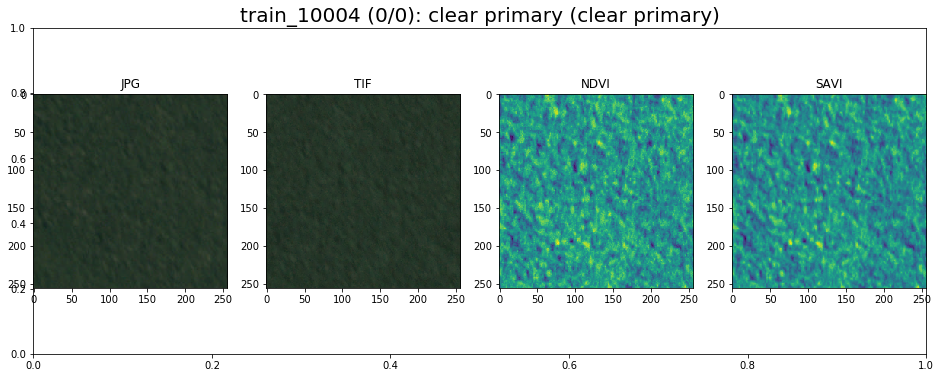

In [200]:
#np.arange(0.1, 1.0, 0.2)
#f = "train_18090"
#f = "train_1560"
f = "train_10004"
#f = "train_10142"
plot_choice(f)
#match_percentiles(f, load_tif(f), load_jpg(f))
#plt.show()

In [139]:
def show_index_grid(img):
    fig = plt.figure()
    fig.set_size_inches(16, 6)
    for grid_row in range(0, 4):
        grid_row_end = grid_row + 1
        for grid_column in range(0, 4):
            grid_column_end = grid_column + 1            
            cropped = img[(grid_column*64):(grid_column_end*64), (grid_row*64):(grid_row_end*64)]
            a = fig.add_subplot(1, 16, (grid_column * 4 + grid_row) + 1)
            plt.imshow(cropped)
    plt.show()
    
def compute_index_quantiles_for_grid(img):
    result = { }
    for grid_row in range(0, 4):
        grid_row_end = grid_row + 1
        for grid_column in range(0, 4):
            grid_column_end = grid_column + 1            
            cropped = img[(grid_column*64):(grid_column_end*64), (grid_row*64):(grid_row_end*64)]
            result[(grid_column, grid_row)] = list(map(lambda x: np.percentile(cropped, x), np.arange(0.1, 1.0, 0.2)))
    return result
    

/opt/conda/lib/python3.5/site-packages/rasterio/__init__.py:193: UserWarning: Dataset has no geotransform set.  Default transform will be applied (Affine.identity())
  s.start()


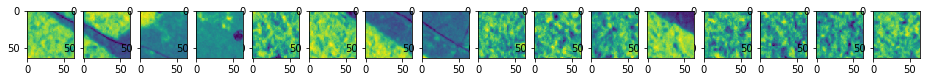

{(0, 0): [0.12110207126015919,
  0.13804767523391673,
  0.14742501414526896,
  0.15265347715673533,
  0.16036263498245765],
 (0, 1): [0.10648883282590835,
  0.11217764485979287,
  0.119714779785625,
  0.12403043090912229,
  0.1288352328172771],
 (0, 2): [0.036283158814876343,
  0.11031542646766337,
  0.12493851963875272,
  0.13172634181474305,
  0.13604511046066375],
 (0, 3): [-0.028949508320999622,
  -0.020987783885666869,
  -0.014441925218774861,
  -0.008298089737256549,
  -0.0039203180472697063],
 (1, 0): [0.31505436705255668,
  0.32701328074701341,
  0.34034926376075614,
  0.35771037709722103,
  0.37141431359208377],
 (1, 1): [0.19607958437839124,
  0.2051100121653946,
  0.20930579103588445,
  0.21452801484944589,
  0.21824008593181649],
 (1, 2): [0.076669507277262142,
  0.093404095377196641,
  0.10221963289504231,
  0.10769794832109081,
  0.11729812805155271],
 (1, 3): [0.071023154017996401,
  0.08466826248262059,
  0.090137643125219269,
  0.09776367656884799,
  0.1025061274386944

In [140]:
name = "train_18090"
tif = load_geotiff(name)
ndvi = compute_ndvi(tif[0], tif[3])
show_index_grid(ndvi)
compute_index_quantiles_for_grid(ndvi)

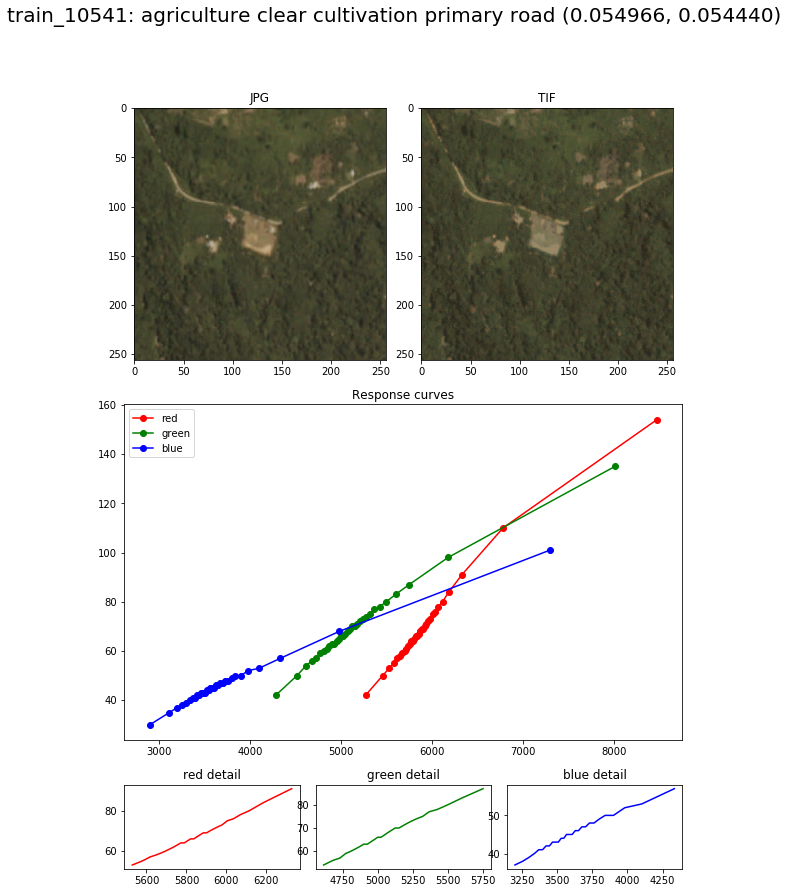

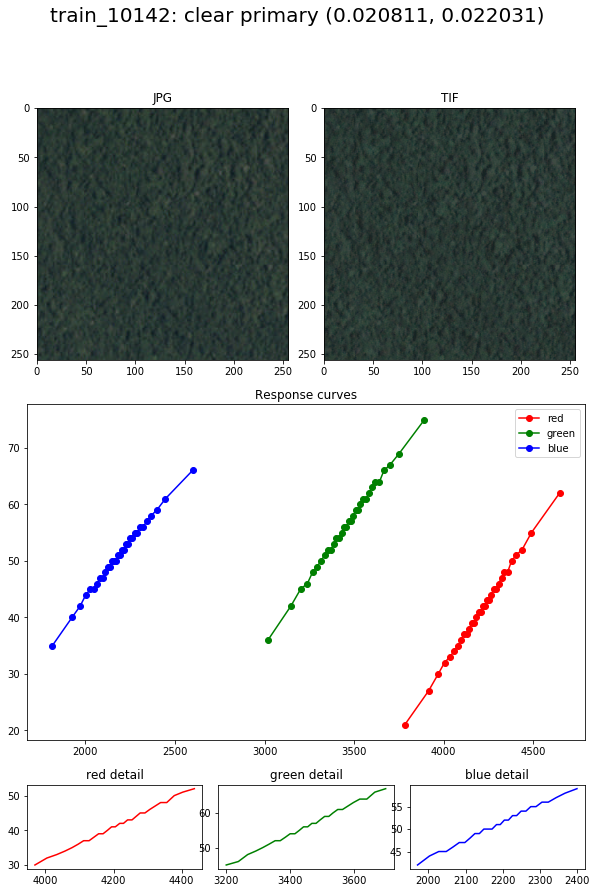

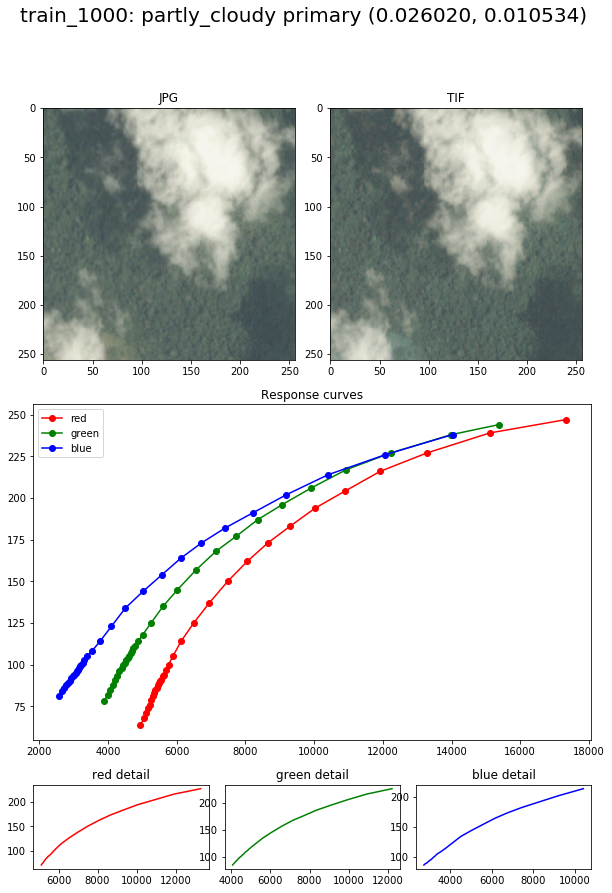

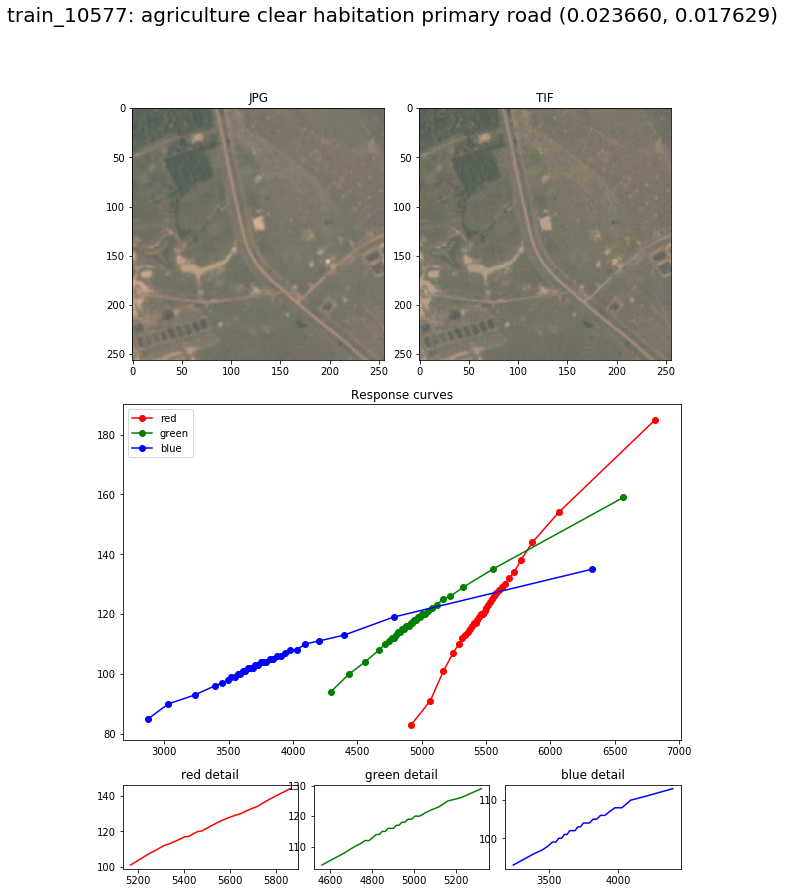

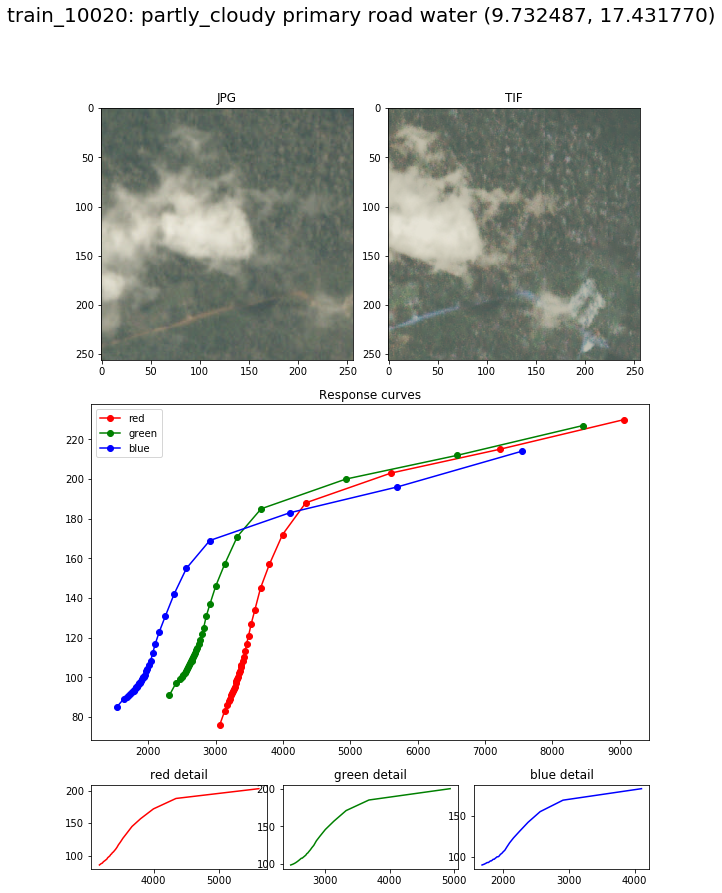

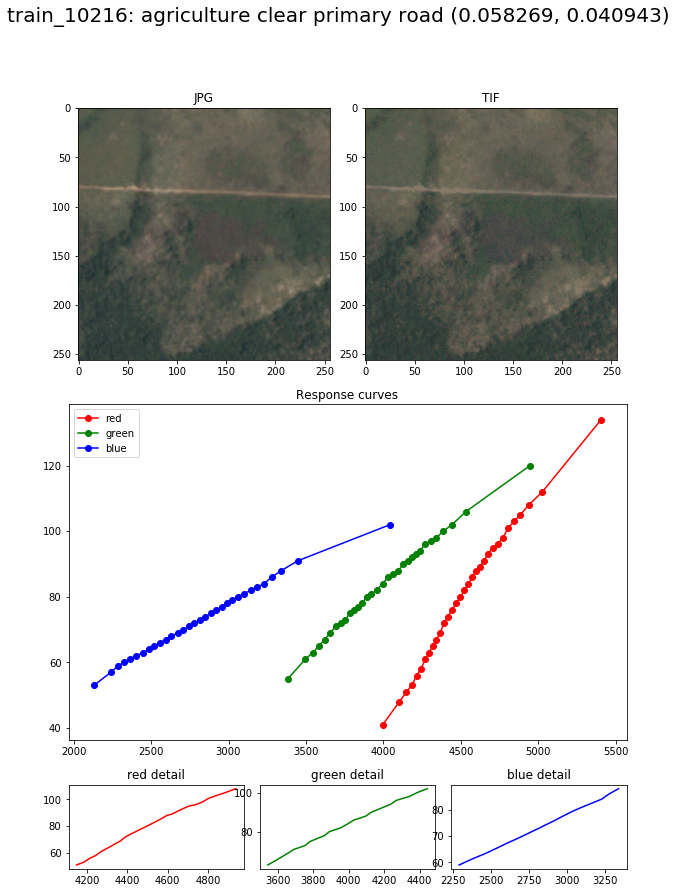

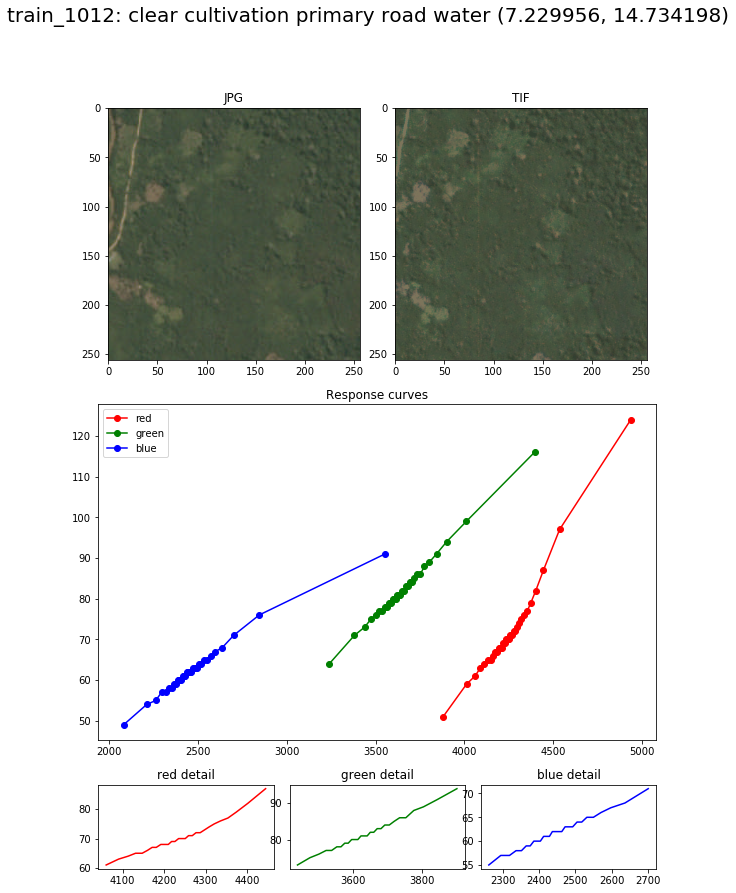

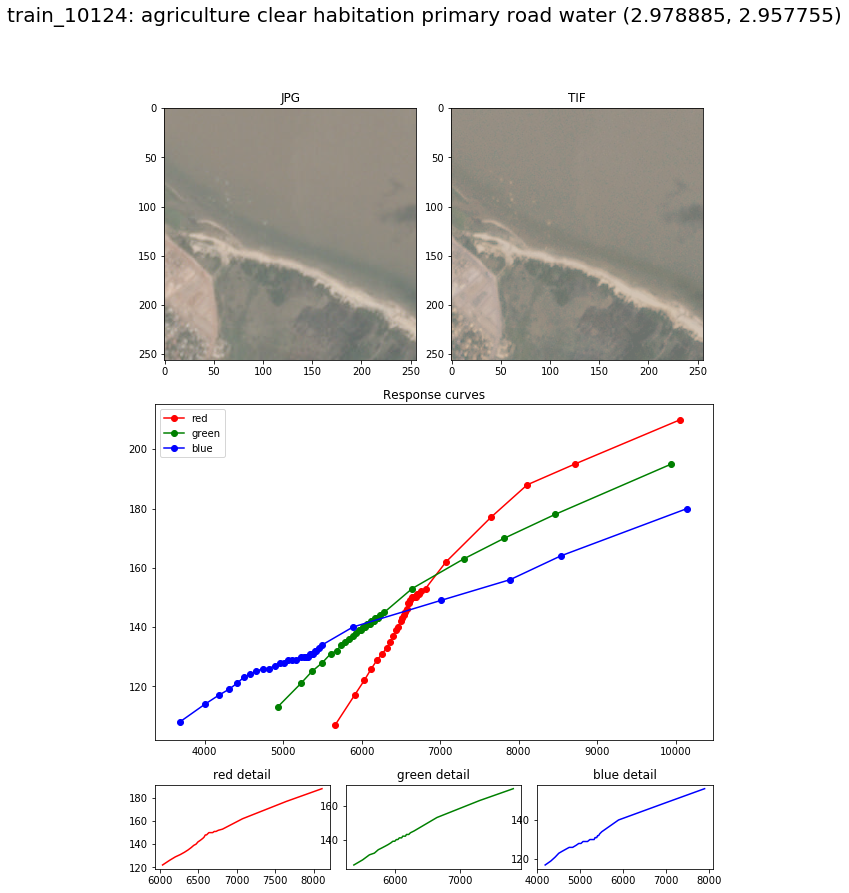

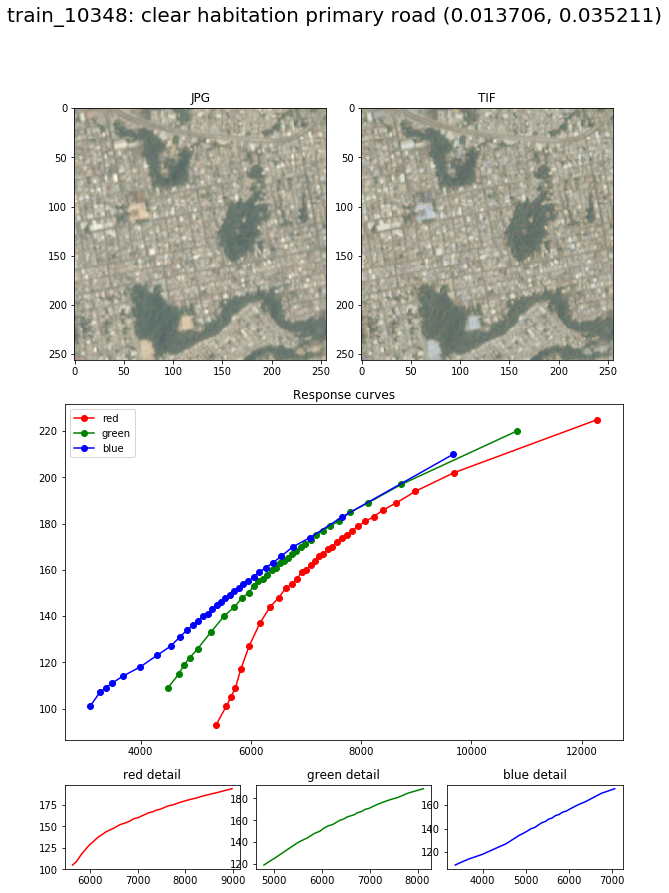

In [80]:
for f in input_images:
    match_percentiles(f, load_tif(f), load_jpg(f))
plt.show()

In [81]:
import random
sample = random.sample(names, 10)
for f in sample:
    match_percentiles(f, load_tif(f), load_jpg(f))
plt.show()

IndexError: single positional indexer is out-of-bounds

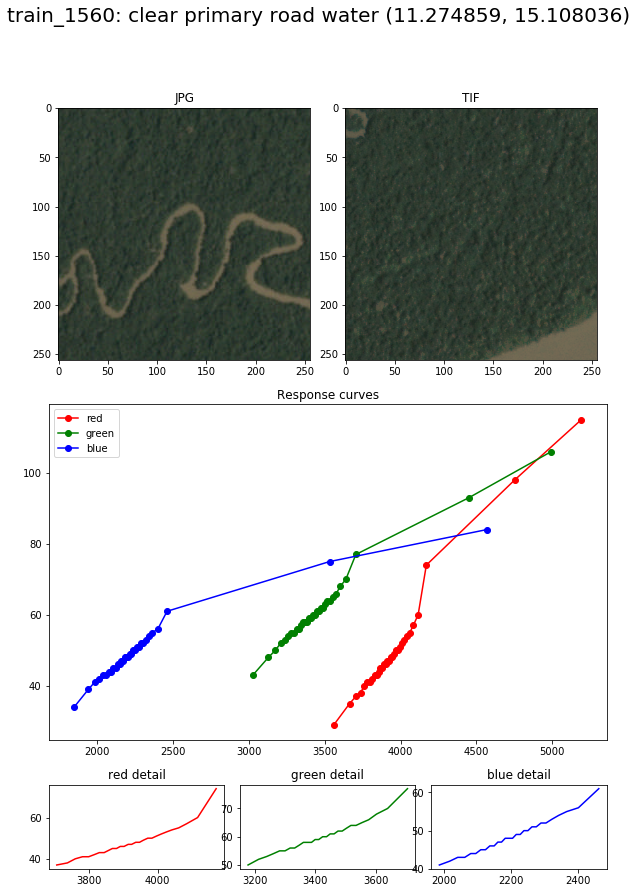

In [117]:
f = "train_1560"
match_percentiles(f, load_tif(f), load_jpg(f))
plt.show()

In [ ]:
f = "train_18090"
match_percentiles(f, load_tif(f), load_jpg(f))
plt.show()

In [163]:
#np.arange(0.1, 1.0, 0.2)[0]
list(enumerate(['a', 'b']))

[(0, 'a'), (1, 'b')]

## Writing out the max_warp scores


In [ ]:
# DON'T DELETE BY ACCIDENT!
fields=['first','second','third']
warp_fn_headers = ','.join(map(lambda x: '"warp_fn%d"' % x, range(0, len(func_list))))
with open("/opt/data/datasets/planet_kaggle/warps.csv", 'w') as f:
    f.write('"image_name","warp",%s\n' % warp_fn_headers)

In [ ]:
names = []

for n in os.listdir('/opt/data/datasets/planet_kaggle/train-jpg'):
    if n.endswith('.jpg'):
        names.append(n.replace('.jpg',''))
        
with open("/opt/data/datasets/planet_kaggle/warps.csv", 'a') as f:
    writer = csv.writer(f)
    #nms = random.sample(names, 250)
    nms = names
    l = len(nms)
    for i, n in enumerate(nms):
        print("Processing %5d of %5d: %s" % (i, l, n))
        warp = max_warp(n)
        warp_fns = []
        for fn in func_list:
            warp_fns.append(max_warp(n, fn=fn))
        others = ','.join(map(lambda x: str(x), warp_fns))
        f.write("%s,%f,%s\n" % (n, warp, others))
    

In [105]:
warp_fn_headers = ','.join(map(lambda x: '"warp_fn%d"' % x, range(0, len(func_list))))
with open("/opt/data/datasets/planet_kaggle/warps-test.csv", 'w') as f:
    f.write('"image_name","warp",%s\n' % warp_fn_headers)

In [106]:
names = []

for n in os.listdir('/opt/data/datasets/planet_kaggle/test-jpg'):
    if n.endswith('.jpg'):
        names.append(n.replace('.jpg',''))
        
with open("/opt/data/datasets/planet_kaggle/warps-test.csv", 'a') as f:
    writer = csv.writer(f)
    #nms = random.sample(names, 250)
    nms = names
    l = len(nms)
    for i, n in enumerate(nms):
        print("Processing %5d of %5d: %s" % (i, l, n))
        warp = max_warp(n)
        warp_fns = []
        for fn in func_list:
            warp_fns.append(max_warp(n, fn=fn))
        others = ','.join(map(lambda x: str(x), warp_fns))
        f.write("%s,%f,%s\n" % (n, warp, others))

Processing     0 of 61191: test_9958
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing     1 of 61191: test_9959
Processing     2 of 61191: test_996
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be unc

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing    12 of 61191: test_9969
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/cond

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing    23 of 61191: test_9979
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing    24 of 61191: test_998
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: erro

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing    33 of 61191: test_9988
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing    34 of 61191: test_9989
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing    35 of 61191: test_999
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing    41 of 61191: test_9995
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation 

Processing    55 of 61191: test_9860
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/mod

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing    64 of 61191: test_9869
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation 

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing    76 of 61191: test_988
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing    77 of 61191: test_9880
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: erro

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   100 of 61191: test_9900
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error:

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   117 of 61191: test_9916
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   118 of 61191: test_9917
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   119 of 61191: test_9918
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   120 of 61191: test_9919
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   121 of 61191: test_992
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/module

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   129 of 61191: test_9927
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/cond

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   145 of 61191: test_9941
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   146 of 61191: test_9942
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   147 of 61191: test_9943
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   148 of 61191: test_9944
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7)

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing   169 of 61191: test_9752
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   17

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   181 of 61191: test_9763
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   182 of 61191: test_9764
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: err

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function fi

Processing   203 of 61191: test_9783
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing   215 of 61191: test_9794
Processing   216 of 61191: test_9795
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   217 of 61191: test_9796
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   218 of 61191: test_9797
/opt/conda/conda-bld

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing   234 of 61191: test_9810
Processing   235 of 61191: test_9811
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   236 of 61191: test_9812
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   237 of 61191: test_9813
/opt/conda/conda-bld

Processing   256 of 61191: test_9830
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/cond

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing   275 of 61191: test_9848
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   276 of 61191: test_9849
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in funct

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/openc

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   299 of 61191: test_9659
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   300 of 61191: test_966
/opt/conda/conda-bld/opencv

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   314 of 61191: test_9672
Processing   315 of 61191: test_9673
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   316 of 61191: test_9674
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/openc

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing   345 of 61191: test_970
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   346 of 61191: test_9700
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   347 of 61191: test_9701
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing   363 of 61191: test_9716
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/cond

Processing   384 of 61191: test_9735
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   385 of 61191: test_9736
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/openc

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing   399 of 61191: test_9538
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   400 of 61191: test_9539
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   401 of 61191: test_954
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   402 of 61191: test_9540
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findT

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing   416 of 61191: test_9553
Processing   417 of 61191: test_9554
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   418 of 61191: test_9555
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   419 of 61191: test_9556
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   420 of 61191: test_9557
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (

Processing   429 of 61191: test_9565
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   430 of 61191: test_9566
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   431 of 61191: test_9567
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing   432 of 61191: test_9568
Processing   433 of 61191: test_9569
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   434 of 61191: test_957
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/mod

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   442 of 61191: test_9577
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   443 of 61191: test_9578
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-b

Processing   468 of 61191: test_960
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   469 of 61191: test_9600
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   470 of 61191: test_9601
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   471 of 61191: test_9602
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   472 of 61191: test_9603
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelate

Processing   487 of 61191: test_9617
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   488 of 61191: test_9618
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in funct

Processing   503 of 61191: test_9631
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   504 of 61191: test_9632
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing   505 of 61191: test_9633
Processing   506 of 61191: test_9634
/opt/conda/conda-bld

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is 

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing   537 of 61191: test_9451
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   538 of 61191: test_9452
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   539 of 61191: test_9453
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going

Processing   553 of 61191: test_9466
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   554 of 61191: test_9467
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   555 of 61191: test_9468
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   556 of 61191: test_9469
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   557 of 61191: test_947
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   558 of 61191: test_9470
/opt/conda/conda-bld/opencv_1

Processing   575 of 61191: test_9486
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing   576 of 61191: test_9487
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   577 of 61191: test_9488
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   578 of 61191: test_9489
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   590 of 61191: test_95
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   591 of 61191: test_950
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing   592 of 61191: test_9500
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   593 of 61191: test_9501
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTra

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/openc

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing   618 of 61191: test_9524
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   619 of 61191: test_9525
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   620 of 61191: test_9526
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1

Processing   633 of 61191: test_9327
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   634 of 61191: test_9328
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/openc

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/openc

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing   658 of 61191: test_935
/opt/conda/conda

Processing   672 of 61191: test_9362
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   673 of 61191: test_9363
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: err


/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/open

Processing   711 of 61191: test_9398
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/cond

Processing   725 of 61191: test_941
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   726 of 61191: test_9410
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   727 of 61191: test_9411
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   728 of 61191: test_9412
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its c

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   749 of 61191: test_9220
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   750 of 61191: test_9221
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   751 of 61191:

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   768 of 61191: test_9238
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing   769 of 61191: test_9239
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: err

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   781 of 61191: test_925
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before 

Processing   798 of 61191: test_9265
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   799 of 61191: test_9266
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   800 of 61191: test_9267
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   801 of 61191: test_9268
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its 

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing   814 of 61191: test_928
Processing   815 of 61191: test_9280
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: erro

Processing   829 of 61191: test_9293
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   830 of 61191: test_9294
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   831 of 61191: test_9295
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/op

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/openc

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   858 of 61191: test_9319
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   859 of 61191: test_932
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   860 of 61191: test_9320
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going 

Processing   867 of 61191: test_9116
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   868 of 61191: test_9117
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   869 of 61191: test_9118
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   870 of 61191: test_9119
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function find

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing   884 of 61191: test_9131
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   885 of 61191: test_9132
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in funct

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing   892 of 61191: test_9139
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   893 of 61191: test_914
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   894 of 61191: test_9140
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   895 of 6119

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing   906 of 61191: test_9151
Processing   907 of 61191: test_9152
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped bef

Processing   926 of 61191: test_917
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   927 of 61191: test_9170
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   928 of 61191: test_9171
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   929 of 61191: test_9172
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findT

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   945 of 61191: test_9187
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before

Processing   957 of 61191: test_9198
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   958 of 61191: test_9199
Processing   959 of 61191: test_92
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   960 of 61191: test_920
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   961 of 61191: test_9200
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated 

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing   974 of 61191: test_9212
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   975 of 61191: test_9213
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: err

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   982 of 61191: test_9009
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   983 of 61191: test_901
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: erro

Processing   991 of 61191: test_9017
Processing   992 of 61191: test_9018
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   993 of 61191: test_9019
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing   994 of 61191: test_902
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) 

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  1012 of 61191: test_9036
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  1021 of 61191: test_9044
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1022 of 61191: test_9045
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1023 of 61191: test_9046
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1024 of 61191: test_9047
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function find

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1042 of 61191: test_9063
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1043 of 61191: test_9064
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1044 of 61191: test_9065
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1045 of 61191: test_9066
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7)

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1064 of 61191: test_9083
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/mod

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  1079 of 61191: test_9097
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1086 of 61191: test_9102
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error:

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  1097 of 61191: test_9112
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1098 of 61191: test_9113
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: err

Processing  1117 of 61191: test_8920
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1118 of 61191: test_8921
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1119 of 61191:

Processing  1136 of 61191: test_8938
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1137 of 61191: test_8939
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: err

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  1151 of 61191: test_8951
/opt/conda/cond

Processing  1163 of 61191: test_8962
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1164 of 61191: test_8963
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1165 of 61191: test_8964
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1166 of 61191: test_8965
Processing  1167 of 61191: test_8966
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelat

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  1175 of 61191: test_8973
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1176 of 61191: test_8974
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1177 of 61191: test_8975
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1191 of 61191: test_8988
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before

Processing  1206 of 61191: test_900
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1207 of 61191: test_9000
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1208 of 61191: 

Processing  1226 of 61191: test_8808
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1227 of 61191: test_8809
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1228 of 61191: test_881
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1229 of 61191: test_8810
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its c

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1238 of 61191: test_8819
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/mod

Processing  1249 of 61191: test_8829
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1250 of 61191: test_883
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/m

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  1266 of 61191: test_8844
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1267 of 61191: test_8845
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: err

Processing  1281 of 61191: test_8858
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1282 of 61191: test_8859
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1283 of 61191: test_886
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1284 of 61191: test_8860
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1285 of 61191: test_8861
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/module

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1293 of 61191: test_8869
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1294 of 61191: test_887
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: erro

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1307 of 61191: test_8881
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1308 of 61191: test_8882
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1309 of 61191: test_8883
Processing  1310 of 61191: test_8884
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7)

Processing  1323 of 61191: test_8896
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1324 of 61191: test_8897
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1325 of 61191: test_8898
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1326 of 61191: test_8899
Processing  1327 of 61191: test_89
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  1344 of 61191: test_8703
/opt/conda/cond

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may 

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  1375 of 61191: test_8731
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation 

Processing  1388 of 61191: test_8743
Processing  1389 of 61191: test_8744
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in funct

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  1402 of 61191: test_8756
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1403 of 61191: test_8757
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  1414 of 61191: test_8767
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1415 of 61191: test_8768
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1416 of 61191: test_8769
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1417 of 611

Processing  1430 of 61191: test_8781
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1431 of 61191: test_8782
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: err

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  1442 of 61191: test_8792
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation 

Processing  1456 of 61191: test_8594
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1457 of 61191: test_8595
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  1458 of 61191: test_8596
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1459 of 61191: test_8597
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1460 of 61191: test_8598
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (

Processing  1481 of 61191: test_8616
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1482 of 61191: test_8617
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in funct

Processing  1491 of 61191: test_8625
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1492 of 61191: test_8626
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: err

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  1499 of 61191: test_8632
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1500 of 61191: test_8633
Processing  1501 of 61191: test_8634
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1502 of 61191: test_8635
/opt/conda/conda-bld

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1513 of 61191: test_8645
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1514 of 61191: test_8646
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1515 of 61191: test_8647
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  1528 of 61191: test_8659
Processing  1529 of 61191: test_866
Processing  1530 of 61191: test_8660
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1531 of 61191: test_8661
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1532 of 61191: test_8662
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-

Processing  1545 of 61191: test_8674
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1546 of 61191: test_8675
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1547 of 61191: test_8676
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1548 of 61191: test_8677
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1549 of 61191: test_8678
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1550 of 61191: test_8679
Processing  1551 of 61191: t

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1564 of 61191: test_8691
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/mod

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  1582 of 61191: test_8497
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  158

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1596 of 61191: test_8509
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1597 of 61191: test_851
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorr

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  1609 of 61191: test_8520
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/cond

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  1620 of 61191: test_8530
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/cond

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  1628 of 61191: test_8538
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation 

Processing  1646 of 61191: test_8554
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1647 of 61191: test_8555
Processing  1648 of 61191: test_8556
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1649 of 61191: test_8557
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1650 of 61191: test_8558
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1651 of 61191: test_8559
/opt/conda/conda-bld/opencv_

Processing  1676 of 61191: test_8581
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/mod

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  1685 of 61191: test_8379
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  168

Processing  1699 of 61191: test_8391
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1700 of 61191: test_8392
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in funct

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  1718 of 61191: test_8408
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1719 of 61191: test_8409
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1720 of 61191: test_841
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1729 of 61191: test_8418
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1730 of 61191: test_8419
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1731 of 61191: test_842
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1732 of 61191: test_8420
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1733 of 61191: test_8421
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/module

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1743 of 61191: test_8430
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1744 of 61191: test_8431
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1745 of 61191: test_8432
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1746 of 61191: test_8433
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1747 of 61191: test_8434
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modul

Processing  1765 of 61191: test_8450
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1766 of 61191: test_8451
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1782 of 61191: test_8466
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1783 of 61191: test_8467
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1784 of 61191: test_8468
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1785 of 61191: test_8469
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function find

Processing  1792 of 61191: test_8475
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1793 of 61191: test_8476
Processing  1794 of 61191: test_8477
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1795 of 61191: test_8478
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1801 of 61191: test_8272
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/mod

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1816 of 61191: test_8286
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1817 of 61191: test_8287
Processing  1818 of 61191: test_8288
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  1819 of 61191: test_8289
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function find

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1838 of 61191: test_8305
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1839 of 61191: test_8306
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1840 of 61191: test_8307
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1841 of 61191: test_8308
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1842 of 61191: test_8309
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modul

Processing  1864 of 61191: test_8329
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1865 of 61191: test_833
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1866 of 61191: 

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  1888 of 61191: test_8350
Processing  1889 of 61191: test_8351
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped bef

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1906 of 61191: test_8367
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  1926 of 61191: test_8174
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1927 of 61191: test_8175
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1928 of 61191: test_8176
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1941 of 61191: test_8188
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1942 of 61191: test_8189
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to

Processing  1958 of 61191: test_8202
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1959 of 61191: test_8203
Processing  1960 of 61191: test_8204
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be un

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1970 of 61191: test_8213
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1971 of 61191: test_8214
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1972 of 61191: test_8215
Processing  1973 of 61191: test_8216
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1974 of 61191: test_8217
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modul

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1982 of 61191: test_8224
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1983 of 61191: test_8225
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1984 of 61191: test_8226
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1985 of 61191: test_8227
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  1986 of 61191: test_8228
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modul

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  1995 of 61191: test_8236
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error:

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2011 of 61191: test_8250
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2012 of 61191: test_8251
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2013 of 61191: test_8252
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2014 of 61191: test_8253
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2015 of 61191: test_8254
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modul

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  2029 of 61191: test_8267
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation 

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  2043 of 61191: test_8069
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2044 of 61191: test_807
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2045 of 61191: test_8070
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2046 of 61191: test_8071
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findT

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2071 of 61191: test_8094
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2072 of 61191: test_8095
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/openc

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2082 of 61191: test_8103
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function

Processing  2094 of 61191: test_8114
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation 

Processing  2115 of 61191: test_8133
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2116 of 61191: test_8134
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2117 of 61191: test_8135
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2118 of 61191: test_8136
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its 

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  2134 of 61191: test_8150
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2135 of 61191: test_8151
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2136 of 61191: test_8152
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1

Processing  2153 of 61191: test_7958
Processing  2154 of 61191: test_7959
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2155 of 61191: test_796
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2156 of 61191: test_7960
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2157 of 61191: test_7961
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelate

Processing  2176 of 61191: test_7979
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/cond

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/openc

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/openc

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/openc

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  2233 of 61191: test_8029
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2234 of 61191: test_803
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2235 of 61191: test_8030
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2249 of 61191: test_8043
Processing  2250 of 61191: test_8044
/opt/conda/conda-bld/openc

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  2264 of 61191: test_8057
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/cond

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2275 of 61191: test_7857
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/cond

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2283 of 61191: test_7864
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2284 of 61191: test_7865
Processing  2285 of 61191: test_7866
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2286 of 61191: test_7867
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2287 of 61191: test_7868
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2288 of 61191: test_7869
/opt/conda/conda-bld/opencv_

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2301 of 61191: test_7880
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/cond

Processing  2316 of 61191: test_7894
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/cond

Processing  2330 of 61191: test_7906
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2331 of 61191: test_7907
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  2345 of 61191: test_792
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2346 of 61191: test_7920
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2347 of 61191: test_7921
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  2355 of 61191: test_7929
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2356 of 61191: test_793
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2357 of 61191: test_7930
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2358 of 61191: test_7931
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findT

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  2380 of 61191: test_7951
Processing  2381 of 61191: test_7952
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2382 of 61191: test_7953
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is 

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2410 of 61191: test_7768
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2411 of 61191: test_7769
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2412 of 61191: test_777
Processing  2413 of 61191: test_7770
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findT

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2424 of 61191: test_7780
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2425 of 61191: test_7781
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2426 of 61191: test_7782
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2427 of 61191: test_7783
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2428 of 61191: test_7784
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modul

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before it

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  2449 of 61191: test_7802
Processing  2450 of 61191: test_7803
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2451 of 61191: test_7804
Processing  2452 of 61191: test_7805
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2453 of 

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is 

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  2474 of 61191: test_7825
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2475 of 61191: test_7826
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2476 of 61191: test_7827
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2477 of 611

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  2490 of 61191: test_784
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2491 of 61191: test_7840
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2492 of 61191: test_7841
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2493 of 61191: test_7842
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findT

Processing  2507 of 61191: test_7644
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/openc

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  2525 of 61191: test_7660
/opt/conda/cond

Processing  2536 of 61191: test_7670
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2537 of 61191: test_7671
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2538 of 61191: test_7672
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/op

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  2554 of 61191: test_7687
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2555 of 61191: test_7688
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in funct

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  2567 of 61191: test_7699
Processing  2568 of 61191: test_77
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2569 of 61191: test_770
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2586 of 61191: test_7715
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2587 of 61191: test_7716
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: err

Processing  2596 of 61191: test_7724
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2597 of 61191: test_7725
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2598 of 61191: test_7726
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  2609 of 61191: test_7736
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation 

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  2622 of 61191: test_7537
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation 

Processing  2634 of 61191: test_7548
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2635 of 61191: test_7549
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2636 of 61191: test_755
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTran

Processing  2652 of 61191: test_7564
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2653 of 61191: test_7565
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2654 of 61191: test_7566
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  2655 of 61191: test_7567
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function find

Processing  2673 of 61191: test_7583
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2674 of 61191: test_7584
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2675 of 61191: test_7585
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2676 of 61191: test_7586
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2677 of 61191: test_7587
Processing  2678 of 61191: test_7588
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2679 of 61191: t

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/openc

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  2708 of 61191: test_7614
/opt/conda/cond

Processing  2728 of 61191: test_7632
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2729 of 61191: test_7633
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in funct

Processing  2748 of 61191: test_744
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2749 of 61191: test_7440
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2750 of 61191: test_7441
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2751 of 61191: test_7442
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its c

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  2765 of 61191: test_7455
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2766 of 61191: test_7456
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2767 of 61191: test_7457
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is 

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2799 of 61191: test_7486
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2800 of 61191: test_7487
Processing  2801 of 61191: test_7488
Processing  2802 of 61191: test_7489
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2803 of 61191: test_749
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2815 of 61191: test_750
Processing  2816 of 61191: test_7500
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in functi

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  2826 of 61191: test_751
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation i

Processing  2838 of 61191: test_7520
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2839 of 61191: test_7521
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2840 of 61191:

Processing  2857 of 61191: test_7327
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2858 of 61191: test_7328
Processing  2859 of 61191: test_7329
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTra

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/openc

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2878 of 61191: test_7346
Processing  2879 of 61191: test_7347
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2880 of 61191: test_7348
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2881 of 61191: test_7349
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2882 of 61191: test_735
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2883 of 61191: test_7350
/opt/conda/conda-bld/opencv_1

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2904 of 61191: test_737
Processing  2905 of 61191: test_7370
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2906 of 61191: test_7371
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2907 of 61191: test_7372
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findT

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2920 of 61191: test_7384
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2921 of 61191: test_7385
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2922 of 61191: test_7386
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/op

Processing  2952 of 61191: test_7412
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  2964 of 61191: test_7423
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2965 of 61191: test_7424
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: err

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  2977 of 61191: test_7224
Processing  2978 of 61191: test_7225
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2979 of 61191: test_7226
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2980 of 61191: test_7227
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function find

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2986 of 61191: test_7232
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  2987 of 61191: test_7233
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncor

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  2999 of 61191: test_7244
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3000 of 61191: test_7245
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in funct

Processing  3014 of 61191: test_7258
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3015 of 61191: test_7259
Processing  3016 of 61191: test_726
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/ope

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/openc

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  3047 of 61191: test_7288
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is 

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3083 of 61191: test_732
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3084 of 61191: test_7320
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3085 of 61191: test_7321
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3086 of 61191: test_7322
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) 

Processing  3097 of 61191: test_7121
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/cond

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/openc

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  3134 of 61191: test_7155
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  313

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  3160 of 61191: test_7179
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3161 of 61191: test_718
Processing  3162 of 61191: test_7180
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.

Processing  3175 of 61191: test_7192
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3176 of 61191: test_7193
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in funct

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3192 of 61191: test_7207
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3193 of 61191: test_7208
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3194 of 61191: test_7209
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  3195 of 611

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3204 of 61191: test_7218
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/cond

Processing  3216 of 61191: test_7018
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3217 of 61191: test_7019
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3218 of 61191:

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  3227 of 61191: test_7028
Processing  3228 of 61191: test_7029
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in funct

Processing  3245 of 61191: test_7044
Processing  3246 of 61191: test_7045
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3247 of 61191: test_7046
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3248 of 61191: test_7047
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its 

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  3263 of 61191: test_7060
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation 

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3274 of 61191: test_7070
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3275 of 61191: test_7071
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: err

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  3289 of 61191: test_7084
/opt/conda/cond

Processing  3305 of 61191: test_7099
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  3306 of 61191: test_71
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  3307 of 61191: test_710
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: err

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is 

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3335 of 61191: test_6915
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3336 of 61191: test_6916
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3337 of 61191: test_6917
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going

Processing  3349 of 61191: test_6928
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3350 of 61191: test_6929
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/

Processing  3365 of 61191: test_6942
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3366 of 61191: test_6943
Processing  3367 of 61191: test_6944
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3368 of 61191: test_6945
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3369 of 61191: test_6946
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  3378 of 61191: test_6954
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3379 of 61191: test_6955
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3380 of 61191: test_6956
Processing  3381 of 61191: test_6957
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3382 of 61191: test_6958
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  3394 of 61191: test_6969
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3395 of 61191: test_697
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3396 of 61191: test_6970
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3397 of 6119

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/openc

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3414 of 61191: test_6987
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3415 of 61191: test_6988
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3416 of 61191: test_6989
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3417 of 61191: test_699
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3418 of 61191: test_6990
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/module

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  3432 of 61191: test_7001
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3433 of 61191: test_7002
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: err

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  3448 of 61191: test_6806
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3449 of 61191: test_6807
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3450 of 61191: test_6808
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3451 of 611

Processing  3464 of 61191: test_6820
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error:

Processing  3482 of 61191: test_6837
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3483 of 61191: test_6838
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3484 of 61191: test_6839
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its con

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/openc

Processing  3510 of 61191: test_6862
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/mod

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/openc

Processing  3543 of 61191: test_6892
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3544 of 61191: test_6893
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/openc

Processing  3563 of 61191: test_67
Processing  3564 of 61191: test_670
Processing  3565 of 61191: test_6700
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3566 of 61191: test_6701
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3567 of 61191: test_6702
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3568 of 61191: test_6703
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3569 of 61191: test

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3579 of 61191: test_6713
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before

Processing  3595 of 61191: test_6728
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3596 of 61191: test_6729
Processing  3597 of 61191: test_673
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTran

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  3608 of 61191: test_674
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3609 of 61191: test_6740
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in functi

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  3615 of 61191: test_6746
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  361

Processing  3626 of 61191: test_6756
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  3627 of 61191: test_6757
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3628 of 61191: test_6758
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be un

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3650 of 61191: test_6778
Processing  3651 of 61191: test_6779
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3652 of 61191: test_678
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3653 of 61191: test_6780
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findT

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  3669 of 61191: test_6795
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3670 of 61191: test_6796
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: err

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3680 of 61191: test_6594
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3681 of 61191: test_6595
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3682 of 61191: test_6596
Processing  3683 of 61191: test_6597
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3684 of 61191: test_6598
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3685 of 61191: test_6599
/opt/conda/conda-bld/opencv_

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may 

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  3711 of 61191: test_6621
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3712 of 61191: test_6622
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3713 of 61191: test_6623
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3714 of 61191: test_6624
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its 

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/openc

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  3733 of 61191: test_6641
Processing  3734 of 61191: test_6642
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3735 of 61191: test_6643
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1

Processing  3743 of 61191: test_6650
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3744 of 61191: test_6651
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3745 of 61191: test_6652
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1

Processing  3758 of 61191: test_6664
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  3777 of 61191: test_6681
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3778 of 61191: test_6682
Processing  3779 of 61191: test_6683
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/openc

Processing  3809 of 61191: test_65
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3810 of 61191: test_650
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3811 of 61191: test_6500
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3833 of 61191: test_6520
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/cond

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  3840 of 61191: test_6527
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-b

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  3862 of 61191: test_6547
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3863 of 61191: test_6548
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3864 of 61191: test_6549
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3865 of 611

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  3882 of 61191: test_6565
Processing  3883 of 61191: test_6566
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3900 of 61191: test_6581
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3901 of 61191: test_6582
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3902 of 61191: test_6583
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3903 of 61191: test_6584
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3904 of 61191: test_6585
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modul

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  3926 of 61191: test_6394
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3927 of 61191: test_6395
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in funct

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  3935 of 61191: test_6401
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation 

Processing  3949 of 61191: test_6414
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3950 of 61191: test_6415
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3951 of 61191: test_6416
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1

Processing  3959 of 61191: test_6423
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3960 of 61191: test_6424
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3961 of 61191: test_6425
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3962 of 61191: test_6426
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  3963 of 61191: test_6427
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modul

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  3976 of 61191: test_6439
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/cond

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  3993 of 61191: test_6454
/opt/conda/cond

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  4003 of 61191: test_6463
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4004 of 61191: test_6464
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in funct

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  4013 of 61191: test_6472
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4014 of 61191: test_6473
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4015 of 61191: test_6474
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1

Processing  4029 of 61191: test_6276
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4030 of 61191: test_6277
Processing  4031 of 61191: test_6278
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4032 of 61191: test_6279
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4033 of 61191: test_628
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-

Processing  4047 of 61191: test_6292
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4048 of 61191: test_6293
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4049 of 61191: test_6294
Processing  4050 of 61191: test_6295
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld

Processing  4061 of 61191: test_6304
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4062 of 61191: test_6305
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in funct

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  4072 of 61191: test_6314
/opt/conda/cond

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/openc


Processing  4098 of 61191: test_6338
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4099 of 61191: test_6339
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4100 of 61191: test_634
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1

Processing  4112 of 61191: test_6350
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4113 of 61191: test_6351
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4114 of 61191: test_6352
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4115 of 61191: test_6353
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its 

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4127 of 61191: test_6364
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4128 of 61191: test_6365
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/

Processing  4139 of 61191: test_6375
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4140 of 61191: test_6376
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4141 of 61191: test_6166
Processing  4142 of 61191: test_6167
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  4153 of 61191: test_6177
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4154 of 61191: test_6178
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4155 of 61191: test_6179
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4156 of 61191: test_618
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its c

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  4169 of 61191: test_6191
Processing  417

Processing  4181 of 61191: test_6201
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  4182 of 61191: test_6202
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4183 of 61191: test_6203
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4184 of 61191: test_6204
/opt/conda/conda-bld

Processing  4197 of 61191: test_6216
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4198 of 61191: test_6217
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4199 of 61191: test_6218
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4200 of 61191: test_6219
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4201 of 61191: test_622
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4202 of 61191: test_6220
/opt/conda/conda-bld/opencv_1

Processing  4219 of 61191: test_6236
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/cond

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  4233 of 61191: test_6249
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  423

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4245 of 61191: test_626
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4246 of 61191: test_6260
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4247 of 61191: test_6261
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4248 of 6119

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/openc

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  4286 of 61191: test_6086
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  428

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  4303 of 61191: test_6100
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4304 of 61191: test_6101
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4305 of 61191: test_6102
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  4322 of 61191: test_6118
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  432

Processing  4333 of 61191: test_6128
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4334 of 61191: test_6129
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4335 of 61191: test_613
Processing  4336 of 61191: test_6130
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4337 of 61191: test_6131
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  4345 of 61191: test_6139
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4346 of 61191: test_614
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4347 of 61191: test_6140
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  4361 of 61191: test_6153
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  436

Processing  4372 of 61191: test_6163
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4373 of 61191: test_6164
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4374 of 61191: test_6165
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4375 of 61191: test_5956
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its 

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4387 of 61191: test_5967
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/openc

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  4418 of 61191: test_5995
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/cond

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  4437 of 61191: test_6010
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function fi

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  4461 of 61191: test_6032
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4462 of 61191: test_6033
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in funct

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4477 of 61191: test_6047
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4478 of 61191: test_6048
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: err

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  4493 of 61191: test_5851
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  4494 of 61191: test_5852
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in funct

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  4507 of 61191: test_5864
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4508 of 61191: test_5865
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4509 of 61191: test_5866
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may 

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  4537 of 61191: test_5891
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4538 of 61191: test_5892
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4539 of 61191: test_5893
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4540 of 611

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/openc

Processing  4567 of 61191: test_5918
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4568 of 61191: test_5919
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in funct

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  4579 of 61191: test_5929
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation 

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4592 of 61191: test_5940
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4593 of 61191: test_5941
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: err

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4606 of 61191: test_5953
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/cond

Processing  4616 of 61191: test_5751
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4617 of 61191: test_5752
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4618 of 61191: test_5753
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  4619 of 611

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4630 of 61191: test_5764
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4631 of 61191: test_5765
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4632 of 61191: test_5766
Processing  4633 of 61191: test_5767
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4634 of 61191: test_5768
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modul

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  4652 of 61191: test_5784
/opt/conda/cond

Processing  4664 of 61191: test_5795
Processing  4665 of 61191: test_5796
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4666 of 61191: test_5797
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4667 of 61191: test_5798
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function find

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  4677 of 61191: test_5806
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may 

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-b

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may 

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4742 of 61191: test_5654
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error:

Processing  4754 of 61191: test_5665
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4755 of 61191: test_5666
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4756 of 61191: test_5667
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/op

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  4766 of 61191: test_5676
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  476

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/openc

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4796 of 61191: test_5702
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4797 of 61191: test_5703
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  4808 of 61191: test_5713
/opt/conda/cond

Processing  4826 of 61191: test_573
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4827 of 61191: test_5730
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4828 of 61191: test_5731
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4829 of 61191: test_5732
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4830 of 61191: test_5733
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelate

Processing  4836 of 61191: test_5739
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/cond

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/openc

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/openc

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may 

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4886 of 61191: test_5573
Processing  4887 of 61191: test_5574
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4888 of 61191: test_5575
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4897 of 61191: test_5583
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error:

Processing  4907 of 61191: test_5592
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  4908 of 61191: test_5593
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in funct

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  4919 of 61191: test_5602
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation 

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  4932 of 61191: test_5614
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4933 of 61191: test_5615
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in funct

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  4944 of 61191: test_5625
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4945 of 61191: test_5626
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4946 of 61191: test_5627
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  4957 of 61191: test_5637
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4958 of 61191: test_5638
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4959 of 61191: test_5639
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1

Processing  4983 of 61191: test_545
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4984 of 61191: test_5450
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4985 of 61191: test_5451
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  4986 of 6119

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  4998 of 61191: test_5463
/opt/conda/cond

Processing  5013 of 61191: test_5477
Processing  5014 of 61191: test_5478
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5015 of 61191: test_5479
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be un

Processing  5031 of 61191: test_5493
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5032 of 61191: test_5494
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  5033 of 61191: test_5495
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5034 of 61191: test_5496
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function find

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5045 of 61191: test_5505
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  5062 of 61191: test_5520
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5063 of 61191: test_5521
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5064 of 61191: test_5522
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  5074 of 61191: test_5531
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/cond

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/openc

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  5113 of 61191: test_5356
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5114 of 61191: test_5357
Processing  5115 of 61191: test_5358
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5133 of 61191: test_5374
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5134 of 61191: test_5375
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5135 of 61191: test_5376
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going

Processing  5150 of 61191: test_539
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5151 of 61191: test_5390
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: erro

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  5165 of 61191: test_5402
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5166 of 61191: test_5403
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: err

Processing  5182 of 61191: test_5418
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5183 of 61191: test_5419
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5184 of 61191: test_542
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5185 of 61191: test_5420
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5186 of 61191: test_5421
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5187 of 61191: test_5422
/opt/conda/conda-bld/opencv_1

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  5197 of 61191: test_5220
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5198 of 61191: test_5221
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5199 of 61191: test_5222
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/openc

Processing  5232 of 61191: test_5252
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5233 of 61191: test_5253
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  5234 of 61191: test_5254
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function fi

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  5255 of 61191: test_5273
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5256 of 61191: test_5274
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5257 of 61191: test_5275
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5258 of 61191: test_5276
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function find

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  5271 of 61191: test_5288
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5272 of 61191: test_5289
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5273 of 61191: test_529
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5274 of 6119

Processing  5283 of 61191: test_5299
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/cond

Processing  5301 of 61191: test_5314
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5302 of 61191: test_5315
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: err

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  5317 of 61191: test_5118
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5318 of 61191: test_5119
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5319 of 61191: test_512
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/ope

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  5331 of 61191: test_5130
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  533


/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  5341 of 61191: test_514
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation 

Processing  5354 of 61191: test_5151
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5355 of 61191: test_5152
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5356 of 61191: test_5153
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/openc

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  5381 of 61191: test_5176
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation 

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  5400 of 61191: test_5193
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5401 of 61191: test_5194
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: err

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5420 of 61191: test_5210
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5421 of 61191: test_5211
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5422 of 61191: test_5212
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going

Processing  5441 of 61191: test_5019
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/cond

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5465 of 61191: test_5040
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5466 of 61191: test_5041
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5467 of 61191: test_5042
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/op

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/openc

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is 

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5506 of 61191: test_5078
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5507 of 61191: test_5079
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5508 of 61191: test_508
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/ope

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may 

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/openc

Processing  5539 of 61191: test_5107
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  5540 of 61191: test_5108
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  5553 of 61191: test_491
Processing  5554

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  5561 of 61191: test_4917
Processing  556

Processing  5576 of 61191: test_4930
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function

Processing  5594 of 61191: test_4947
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5595 of 61191: test_4948
Processing  5596 of 61191: test_4949
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTra

Processing  5619 of 61191: test_497
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5620 of 61191: test_4970
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5621 of 61191: test_4971
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5622 of 61191: test_4972
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its c

Processing  5633 of 61191: test_4982
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/cond

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  5648 of 61191: test_4996
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/cond

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  5657 of 61191: test_5002
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation 

Processing  5668 of 61191: test_4802
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  5688 of 61191: test_4820
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5689 of 61191: test_4821
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5690 of 61191: test_4822
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5691 of 61191: test_4823
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function find

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5707 of 61191: test_4838
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5708 of 61191: test_4839
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5709 of 61191: test_484
Processing  5710 of 61191: test_4840
Processing  5711 of 61191: test_4841
Processing  5712 of 61191: test_4842
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/mod

Processing  5725 of 61191: test_4854
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5726 of 61191: test_4855
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5727 of 61191: test_4856
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5728 of 61191: test_4857
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its 

Processing  5740 of 61191: test_4868
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5741 of 61191: test_4869
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5742 of 61191: test_487
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5743 of 61191: test_4870
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) 

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5758 of 61191: test_4884
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5759 of 61191: test_4885
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/openc

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  5772 of 61191: test_4897
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5773 of 61191: test_4898
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5774 of 61191: test_4899
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5775 of 61191: test_49
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTr

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5783 of 61191: test_4696
Processing  5784 of 61191: test_4697
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  5801 of 61191: test_4711
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation 

Processing  5809 of 61191: test_4719
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5825 of 61191: test_4733
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5826 of 61191: test_4734
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5827 of 61191: test_4735
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5828 of 61191: test_4736
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5829 of 61191: test_4737
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modul

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5856 of 61191: test_4761
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5857 of 61191: test_4762
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5858 of 61191: test_4763
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5859 of 61191: test_4764
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function find

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  5873 of 61191: test_4777
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5874 of 61191: test_4778
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5875 of 61191: test_4779
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5894 of 61191: test_4796
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5895 of 61191: test_4797
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5896 of 61191: test_4587
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/op

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  5910 of 61191: test_46
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5911 of 61191: test_460
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error:

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  5925 of 61191: test_4612
/opt/conda/cond

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  5937 of 61191: test_4623
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5938 of 61191: test_4624
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5939 of 61191: test_4625
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1

Processing  5955 of 61191: test_464
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  5968 of 61191: test_4651
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  5969 of 61191: test_4652
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  5970 of 61191: test_4653
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  5989 of 61191: test_4670
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  5990 of 61191: test_4671
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in funct

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6010 of 61191: test_469
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modu

Processing  6029 of 61191: test_4496
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6030 of 61191: test_4497
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6031 of 61191: test_4498
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6032 of 61191: test_4499
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6033 of 61191: test_45
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules

Processing  6053 of 61191: test_4517
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation 

Processing  6062 of 61191: test_4525
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  606

Processing  6079 of 61191: test_4540
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6080 of 61191: test_4541
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/openc

Processing  6098 of 61191: test_4558
Processing  6099 of 61191: test_4559
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in funct

Processing  6117 of 61191: test_4575
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  6130 of 61191: test_4376
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6131 of 61191: test_4377
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: err

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  6145 of 61191: test_439
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6146 of 61191: test_4390
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in functi

Processing  6163 of 61191: test_4405
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6164 of 61191: test_4406
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6165 of 61191: test_4407
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6166 of 61191: test_4408
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7)

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6179 of 61191: test_442
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6180 of 61191: test_4420
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: erro

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6189 of 61191: test_4429
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6190 of 61191: test_443
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6191 of 61191: test_4430
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going 

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/openc

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  6225 of 61191: test_4461
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6226 of 61191: test_4462
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6227 of 61191: test_4463
Processing  6228 of 61191: test_4464
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6229 of 61191: test_4465
Processing  6230 of 61191: test_4466
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/mo

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/openc

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  6255 of 61191: test_4278
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation 

Processing  6275 of 61191: test_4296
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6276 of 61191: test_4297
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6277 of 61191: test_4298
Processing  6278 of 61191: test_4299
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld

Processing  6286 of 61191: test_4305
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation 

Processing  6296 of 61191: test_4314
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/cond

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/openc

Processing  6323 of 61191: test_4339
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/cond

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/openc

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6347 of 61191: test_4360
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6348 of 61191: test_4361
Processing  6349 of 61191: test_4362
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function fi

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/openc

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  6385 of 61191: test_4184
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6386 of 61191: test_4185
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6387 of 61191: test_4186
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/openc

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6416 of 61191: test_4211
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6417 of 61191: test_4212
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6418 of 61191: test_4213
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6419 of 61191: test_4214
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6420 of 61191: test_4215
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modul

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  6430 of 61191: test_4224
Processing  6431 of 61191: test_4225
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6432 of 61191: test_4226
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be un

Processing  6442 of 61191: test_4235
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  6443 of 61191: test_4236
Processing  6444 of 61191: test_4237
Processing  6445 of 61191: test_4238
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is go

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  6466 of 61191: test_4257
/opt/conda/cond

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is 

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6484 of 61191: test_40664
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  6501 of 61191: test_4078
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6502 of 61191: test_4079
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in funct

Processing  6513 of 61191: test_4089
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6514 of 61191: test_409
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6515 of 61191: test_4090
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/ope

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6524 of 61191: test_4099
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/cond

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6531 of 61191: test_4104
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/mod

Processing  6548 of 61191: test_412
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6549 of 61191: test_4120
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6550 of 61191: test_4121
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6551 of 61191: test_4122
Processing  6552 of 61191: test_4123
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelate

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  6562 of 61191: test_4132
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6563 of 61191: test_4133
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6564 of 61191: test_4134
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6565 of 61191: test_4135
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function find

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6578 of 61191: test_4147
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6579 of 61191: test_4148
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6580 of 61191: test_4149
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6581 of 611

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is 

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/openc

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6627 of 61191: test_40583
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6628 of 61191: test_40584
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6629 of 61191: test_40585
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6630 of 

Processing  6641 of 61191: test_40596
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in functio

Processing  6656 of 61191: test_40609
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6657 of 61191: test_4061
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6658 of 61191: test_40610
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  6677 of 61191: test_40628
Processing  6678 of 61191: test_40629
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in fun

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  6692 of 61191: test_40641
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/con

Processing  6701 of 61191: test_4065
Processing  6702 of 61191: test_40650
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6703 of 61191: test_40651
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6704 of 61191: test_40652
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-

Processing  6715 of 61191: test_40453
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in functio

Processing  6746 of 61191: test_40481
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6747 of 61191: test_40482
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6748 of 61191: test_40483
Processing  6749 of 61191: test_40484
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6750 of 61191: test_40485
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: err

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6761 of 61191: test_40495
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6762 of 61191: test_40496
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6763 of 61191: test_40497
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6764 of 

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6783 of 61191: test_40514
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6784 of 61191: test_40515
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6785 of 61191: test_40516
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6786 of 

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6798 of 61191: test_40528
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6799 of 61191: test_40529
/opt/conda/conda-bld/ope

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  6812 of 61191: test_40540
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/con

Processing  6833 of 61191: test_40350
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6834 of 61191: test_40351
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6835 of 61191: test_40352
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6849 of 61191: test_40365
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  6850 of 61191: test_40366
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6851 of 61191: test_40367
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6852 of 61191: test_40368
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before 

Processing  6865 of 61191: test_4038
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  6866 of 61191: test_40380
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in func


/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  6884 of 61191: test_40397
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6

Processing  6902 of 61191: test_40412
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6903 of 61191: test_40413
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in fun

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is 

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  6921 of 61191: test_4043
Processing  6922 of 61191: test_40430
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6923 of 61191: test_40431
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6924 of 61191: test_40432
Processing  6925 of 61191: test_40433
Processing  6926 of 61191: test_40434
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6927 of 61191: test_40435
Processing  6928 of

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/openc

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6972 of 61191: test_40267
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  6973 of 61191: test_40268
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/ope

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  6988 of 61191: test_40281
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  6989 of 61191: test_40282
Processing  6990 of 61191: test_40283
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:53

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/openc

Processing  7018 of 61191: test_40308
Processing  7019 of 61191: test_40309
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  7020 of 61191: test_4031
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  7021 of 61191: test_40310
/opt/conda/conda-

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  7032 of 61191: test_40320
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  7033 of 61191: test_40321
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  7034 of 61191: test_40322
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  7035 of 61191: test_40323
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  7036 of 61191: test_40324
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

Processing  7044 of 61191: test_40331
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  7045 of 61191: test_40332
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  7046 of 61191: test_40333
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-

Processing  7060 of 61191: test_40346
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  7061 of 61191: test_40347
/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

Processing  7062 of 6119

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:515: error: (-7) NaN encountered. in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/opencv-3.1.0/modules/video/src/ecc.cpp:530: error: (-7) The algorithm stopped before its convergence. The correlation is going to be minimized. Images may be uncorrelated or non-overlapped in function findTransformECC

/opt/conda/conda-bld/opencv_1491943704081/work/openc

KeyboardInterrupt: 

# Read in warp scores and create subset

In [47]:
warps = pd.merge(pd.read_csv("/opt/data/datasets/planet_kaggle/warps.csv"), 
                 pd.read_csv("/opt/data/datasets/planet_kaggle/train_v2.csv") \
                     .rename(columns={'tags': 'tag_jpgs'}), 
                 on='image_name')

warps = pd.merge(warps, 
                 pd.read_csv("/opt/data/datasets/planet_kaggle/tiff_predictions.csv") \
                     .rename(columns={'tags': 'tag_predicted'}), 
                 on='image_name')

warps['otags_jpgs'] = warps['tag_jpgs'].apply(lambda x: ' '.join(sorted(x.split(' '))))

warps['otags_tiffs'] = warps['tag_predicted'].apply(lambda x: ' '.join(sorted(x.split(' '))))

In [48]:
warps
# v0
#BIG_CUTOFF = 20.0
#CUTOFF = 12.0
#SMALL_CUTOFF = 7.0
#condition = ( \
#             ((warps['warp'] != -1000.0) & (warps['warp'] < CUTOFF) & (warps['warp_blur'] < CUTOFF + 5.0) ) | \
#             ((warps['warp_blur'] != -1000.0) & (warps['warp_blur'] < CUTOFF) \
#              & (warps['warp'] != -1000.0) & (warps['warp'] < CUTOFF)) | \
#             ((warps['warp_blur'] != -1000.0) & (warps['warp_blur'] < SMALL_CUTOFF) \
#              & (warps['warp'] != -1000.0) & (warps['warp'] < BIG_CUTOFF))
#            ) | ( \
#             (warps['tags'] == 'cloudy')
#            )

image_name         warp    warp_blur  \
0       train_9945     0.015281     0.107233   
1       train_9946     6.548263 -1000.000000   
2       train_9947     0.044921     0.061762   
3       train_9948 -1000.000000 -1000.000000   
4       train_9949     0.021101     0.061326   
5        train_995     0.025604     0.035394   
6       train_9950     0.009346     0.054145   
7       train_9951     0.033138     0.023722   
8       train_9952     0.043127     0.028936   
9       train_9953 -1000.000000     5.759324   
10      train_9954     0.047181     0.315782   
11      train_9955     0.016114     0.015826   
12      train_9956     1.021158     1.047881   
13      train_9957     0.036218     0.129085   
14      train_9958     0.056249     0.063839   
15      train_9959     0.004188     0.031576   
16       train_996     0.078461     0.106837   
17      train_9960     0.032602     0.289774   
18      train_9961     0.011991     0.046141   
19      train_9962     0.054537     0.034284   
20      train_9963     1.781654     1.696469   
21      train_9964     0.026539     0.101196   
22      train_9965     0.038375     0.233706   
23      train_9966     0.007055     0.008629   
24      train_9967     2.008079     1.917392   
25      train_9968     0.184641     0.171341   
26      train_9969     0.028352     0.061326   
27       train_997     0.022013     0.020288   
28      train_9970     0.031469     0.062349   
29      train_9971     0.075328     0.169563   
...            ...          ...          ...   
40449  train_10071     7.609096     2.662320   
40450  train_10072     0.014241     0.071128   
40451  train_10073     0.357532 -1000.000000   
40452  train_10074     0.050373     0.058161   
40453  train_10075     0.021040     0.107339   
40454  train_10076     0.029666     0.030252   
40455  train_10077    15.957245    12.799442   
40456  train_10078     0.025730     0.061575   
40457  train_10079 -1000.000000 -1000.000000   
40458   train_1008     0.026198     0.256920   
40459  train_10080     0.093717     0.046933   
40460  train_10081     0.082488 -1000.000000   
40461  train_10082     9.476263     1.931188   
40462  train_10083     0.051541     0.055725   
40463  train_10084     0.025443     0.287345   
40464  train_10085     0.036562     0.101842   
40465  train_10086     0.052986     0.048115   
40466  train_10087     0.054192     0.074732   
40467  train_10088     0.011464     0.099907   
40468  train_10089     0.371260     0.056211   
40469   train_1009     0.050261     0.037003   
40470  train_10090     3.027008     3.009913   
40471  train_10091     0.081327     0.017578   
40472  train_10092     0.017382     0.055170   
40473  train_10093     0.032491     3.884302   
40474  train_10094     6.949410 -1000.000000   
40475  train_10095     0.032393     0.094415   
40476  train_10096 -1000.000000 -1000.000000   
40477  train_10097     0.020072     0.090872   
40478  train_10098     0.015911     0.030383   

                                                tag_jpgs  \
0                              agriculture clear primary   
1              agriculture clear habitation primary road   
2                                          clear primary   
3                                 blooming clear primary   
4                              agriculture clear primary   
5                                          clear primary   
6                                                 cloudy   
7        bare_ground clear habitation primary road water   
8       agriculture clear cultivation primary road water   
9                                          clear primary   
10                                         clear primary   
11             agriculture clear habitation primary road   
12               agriculture partly_cloudy primary water   
13                                         clear primary   
14                                   clear primary water   
15                                 partly_cloudy primary   
16         

In [52]:
BIG_CUTOFF = 20.0
CUTOFF = 11.0
SMALL_CUTOFF = 7.0

# good apples are defined below, must run that cell first.
known_good_apples = blow_down_good_apples + c_mine_good_apples + bloom_good_apples + \
    selective_logging_good_apples + artisinal_mine_good_apples + bare_ground_good_apples + \
    slash_and_burn_good_apples + habitation_good_apples + agriculture_good_apples + \
    cloudy_good_apples + water_good_apples + cultivation_good_apples

def v1_condition():
    return ( \
             ((warps['warp'] != -1000.0) & (warps['warp'] < CUTOFF) & (warps['warp_blur'] < CUTOFF + 5.0) ) | \
             ((warps['warp_blur'] != -1000.0) & (warps['warp_blur'] < CUTOFF) \
              & (warps['warp'] != -1000.0) & (warps['warp'] < CUTOFF)) | \
             ((warps['warp_blur'] != -1000.0) & (warps['warp_blur'] < SMALL_CUTOFF) \
              & (warps['warp'] != -1000.0) & (warps['warp'] < BIG_CUTOFF))
            ) | ( \
             (warps['tags'] == 'cloudy') 
            ) | ( \
             (warps['tags'].str.contains('blow_down')) & (warps['image_name'] != 'train_20677')
            ) | ( \
             (warps['tags'].str.contains('bare_ground')) & \
                 ((warps['warp'] != -1000.0) & (warps['warp'] < 20.0)) | 
                 ((warps['warp_blur'] != -1000.0) & (warps['warp_blur'] < 20.0)) \
            ) 

def v2_condition():
    # Simple but strict
    return ( \
                 ((warps['warp'] != -1000.0) & (warps['warp'] < 3.0)) 
                ) 

def v3up_condition():
     # Strict + include tags
    return ( \
                 ((warps['warp'] != -1000.0) & (warps['warp'] < 3.0)) | \
                 (warps['otags_jpgs'] == warps['otags_tiffs']) | \
                 (warps['image_name'].isin(known_good_apples))
                ) 

condition = v2_condition()
good_apples = warps.loc[condition]
bad_apples = warps.loc[~(condition)]
#n.loc[n['tags'].str.contains('primary')]

bad_apples.count() / warps.count()

image_name       0.35238
warp             0.35238
warp_blur        0.35238
tag_jpgs         0.35238
tag_predicted    0.35238
otags_jpgs       0.35238
otags_tiffs      0.35238
dtype: float64

In [53]:
bad_apples.loc[bad_apples['otags_jpgs'] == bad_apples['otags_tiffs']].shape
#bad_apples.loc[~(bad_apples['otags_jpgs'] == bad_apples['otags_tiffs'])].shape


(8928, 7)

In [54]:
cond = ~((good_apples['warp'] != -1000.0) & (good_apples['warp'] < 3.0))# & \
        #~(good_apples['tag_jpgs'].str.contains("primary")) & \
        #~(good_apples['tag_jpgs'].str.contains("cloudy"))

#cond = good_apples['tags'].str.contains('habitation') & \
#        ((good_apples['warp'] > 2.0))
        
        #((good_apples['warp_blur'] != -1000.0) & (good_apples['warp_blur'] < SMALL_CUTOFF) \
        #      & (good_apples['warp'] != -1000.0) & (good_apples['warp'] < BIG_CUTOFF)) & \
        #((good_apples['warp'] > CUTOFF))
s = good_apples.loc[cond].sample()
print(s)
plot_choice(s.iloc[0]['image_name'])

ValueError: a must be greater than 0

In [55]:
import matplotlib.pyplot as plt
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

ImportError: No module named 'plotly'

In [35]:
def get_counts(df):
    labels = df['tag_jpgs'].apply(lambda x: x.split(' '))
    from collections import Counter, defaultdict
    counts = defaultdict(int)
    count = 0
    for l in labels:
        for l2 in l:
            counts[l2] += 1
            count += 1
    return (count, counts)
    #plt.bar(range(len(counts)), counts.values(), align='center')
    #plt.xticks(range(len(counts)), counts.keys(), rotation='vertical')
    #plt.show()
    
    

In [56]:
(good_count, good_counts) = get_counts(good_apples)
(bad_count, bad_counts) = get_counts(bad_apples)

#assert(set(good_counts.keys()) - set(bad_counts.keys()) == set(['cloudy']))

for k in good_counts:
    gc = good_counts[k]
    bc = bad_counts[k]
    t = gc + bc
    print("%20s: %6d %6d (%0.2f) per. total: %0.2f" % (k, gc, bc, bc / t, (gc+bc) / (good_count + bad_count)))


NameError: name 'get_counts' is not defined

In [92]:
# TODO
#  agriculture
#  clear?
#  cultivation is better
#  partly cloudy
show_counts(bad_apples)

NameError: name 'show_counts' is not defined

In [50]:
bad_apples.to_csv("/opt/data/datasets/planet_kaggle/unaligned_tifs.csv", columns=['image_name'], index=False, header=False)

In [ ]:
l = []
with open("/opt/data/datasets/planet_kaggle/unaligned_tifs.csv") as f:
    l = f.read().split('\n')

In [ ]:
len(l)


In [ ]:
import os
# Find all bad apples of a tag
#label = 'agriculture'
label = 'cultivation'
path = "/opt/data/datasets/planet_kaggle/keeps-%s.csv" % label
bad_path = "/opt/data/datasets/planet_kaggle/nokeeps-habitation.csv"

#cond = bad_apples['tag_jpgs'].str.contains(label) & ~(bad_apples['tag_jpgs'].str.contains('partly_cloudy'))

cond = bad_apples['tag_jpgs'].str.contains(label)
s = bad_apples.loc[cond]['image_name']
keeps = []

if os.path.exists(path):
    cur = set(s) - set(open(path).read().split('\n'))
else:
    cur = set(s)
    
if os.path.exists(bad_path):
    cur = cur - set(open(bad_path).read().split('\n'))

l = len(cur)
for i, f in enumerate(cur):
    plot_choice(f, i+1, l)
    #plt.show()
    a = input()
    if a == 'quit':
        break
    elif a:
        with open(path, "a") as fl:
            fl.write(f + '\n')
        keeps.append(f)
    else:
        with open(bad_path, "a") as fl:
            fl.write(f + '\n')

In [53]:
import os
# Find all bad apples of a tag
path = "/opt/data/datasets/planet_kaggle/keeps-adhoc.csv"
bad_path = "/opt/data/datasets/planet_kaggle/nokeeps-habitation.csv"

#cond = bad_apples['tag_jpgs'].str.contains(label) & ~(bad_apples['tag_jpgs'].str.contains('partly_cloudy'))
keeps = []

def get_bad_apples(cond):
    s = bad_apples.loc[cond]['image_name']
    if os.path.exists(path):
        cur = set(s) - set(open(path).read().split('\n'))
    else:
        cur = set(s)
    
    if os.path.exists(bad_path):
        cur = cur - set(open(bad_path).read().split('\n'))
    return cur

def get_good_apples(cond):
     return set(good_apples.loc[cond]['image_name']) - set(known_good_apples)
    
    
cur = get_bad_apples(bad_apples['tag_jpgs'].str.contains(label))

l = len(cur)
for i, f in enumerate(cur):
    plot_choice(f, i+1, l)
    #plt.show()
    a = input()
    if a == 'quit':
        break
    elif a:
        with open(path, "a") as fl:
            fl.write(f + '\n')
        keeps.append(f)
    else:
        with open(bad_path, "a") as fl:
            fl.write(f + '\n')

In [50]:
blow_down_good_apples = [ 'train_6267',
                          'train_5926',
                          'train_5628',
                        'train_535',
                        'train_4985',
                        'train_4850',
                        'train_4497',
                        'train_40465',
                        'train_3772',
                        'train_36620',
                        'train_3503',
                        'train_34215',
                        'train_33553',
                        'train_29568',
                        'train_5628',
                        'train_25950',
                        'train_25918',
                        'train_23545',
                        'train_22981',
                        'train_5628',
                         'train_19313',
                        'train_18395',
                        'train_15501',
                        'train_15311',
                        'train_15188',
                        'train_13856',
                        'train_11751',
                        'train_10529',
                        'train_10167']

c_mine_good_apples = ['train_7119', 'train_6357', 'train_35558', 'train_30150', 'train_17889', 'train_17948']

bloom_good_apples = ['train_9916',
 'train_9210',
 'train_897',
 'train_8633',
 'train_8358',
 'train_6894',
 'train_537',
 'train_5247',
 'train_4925',
 'train_4680',
 'train_4423',
 'train_39398',
 'train_39274',
 'train_38443',
 'train_38453',
 'train_37434',
 'train_37443',
 'train_3742',
 'train_3652',
 'train_35456',
 'train_33948',
 'train_33954',
 'train_33287',
 'train_33156',
 'train_32245',
 'train_31664',
 'train_31246',
 'train_29914',
 'train_29268',
 'train_2922',
 'train_28878',
 'train_28821',
 'train_27689',
 'train_27352',
 'train_27057',
 'train_25123',
 'train_24439',
 'train_24476',
 'train_24131',
 'train_22663',
 'train_22550',
 'train_22456',
 'train_21247',
 'train_20932',
 'train_19807',
 'train_19391',
 'train_19034',
 'train_18006',
 'train_18053',
 'train_16859',
 'train_15960',
 'train_15302',
 'train_14406',
 'train_13871',
 'train_12513',
 'train_11759',
 'train_11558',
 'train_10989',
 'train_10497',
 'train_10137']

selective_logging_good_apples = ['train_9363',
 'train_9178',
 'train_9198',
 'train_9027',
 'train_8683',
 'train_8111',
 'train_7271',
 'train_7299',
 'train_6685',
 'train_4660',
 'train_4571',
 'train_4511',
 'train_4147',
 'train_4061',
 'train_4006',
 'train_39211',
 'train_39096',
 'train_3792',
 'train_37464',
 'train_36056',
 'train_35331',
 'train_35183',
 'train_34768',
 'train_33803',
 'train_33511',
 'train_3283',
 'train_31824',
 'train_31540',
 'train_31233',
 'train_31137',
 'train_30675',
 'train_30196',
 'train_29600',
 'train_29265',
 'train_29267',
 'train_28541',
 'train_27257',
 'train_26898',
 'train_25837',
 'train_25334',
 'train_24882',
 'train_247',
 'train_24568',
 'train_24103',
 'train_22738',
 'train_2252',
 'train_20917',
 'train_20381',
 'train_19848',
 'train_19653',
 'train_19400',
 'train_19265',
 'train_19055',
 'train_17737',
 'train_1721',
 'train_16116',
 'train_16134',
 'train_15080',
 'train_151',
 'train_14633',
 'train_13965',
 'train_1337',
 'train_12740',
 'train_12620',
 'train_12172',
 'train_12039',
 'train_1183',
 'train_11856',
 'train_10999',
 'train_10187']

artisinal_mine_good_apples = ['train_994',
 'train_9673',
 'train_8390',
 'train_8283',
 'train_7582',
 'train_6459',
 'train_5802',
 'train_5755',
 'train_5312',
 'train_5178',
 'train_4913',
 'train_3956',
 'train_38685',
 'train_37154',
 'train_36317',
 'train_36019',
 'train_33866',
 'train_31420',
 'train_30969',
 'train_30203',
 'train_30024',
 'train_29669',
 'train_29099',
 'train_28849',
 'train_28872',
 'train_286',
 'train_27980',
 'train_2712',
 'train_26808',
 'train_26628',
 'train_24746',
 'train_22799',
 'train_22627',
 'train_22023',
 'train_19996',
 'train_19538',
 'train_19501',
 'train_18469',
 'train_17838',
 'train_17278',
 'train_17318',
 'train_17005',
 'train_16796',
 'train_14660',
 'train_13344',
 'train_12914',
 'train_12858',
 'train_1115',
 'train_10990']

slash_and_burn_good_apples = ['train_8993',
 'train_728',
 'train_7056',
 'train_6869',
 'train_6278',
 'train_4460',
 'train_40446',
 'train_38594',
 'train_38514',
 'train_38286',
 'train_36396',
 'train_35905',
 'train_35588',
 'train_35633',
 'train_33164',
 'train_31363',
 'train_29847',
 'train_28907',
 'train_2874',
 'train_27160',
 'train_24845',
 'train_23929',
 'train_22861',
 'train_20871',
 'train_20874',
 'train_18986',
 'train_16660',
 'train_15860',
 'train_15589',
 'train_15309',
 'train_1502',
 'train_13269',
 'train_13096',
 'train_12953',
 'train_12772',
 'train_12661',
 'train_12189',
 'train_11034']

bare_ground_good_apples = open("/opt/data/datasets/planet_kaggle/keeps-bare_ground.csv").read().split('\n')

habitation_good_apples = open("/opt/data/datasets/planet_kaggle/keeps-habitation.csv").read().split('\n')

agriculture_good_apples = open("/opt/data/datasets/planet_kaggle/keeps-agriculture.csv").read().split('\n')

cloudy_good_apples = open("/opt/data/datasets/planet_kaggle/keeps-cloudy.csv").read().split('\n')

water_good_apples = open("/opt/data/datasets/planet_kaggle/keeps-water.csv").read().split('\n')

cultivation_good_apples = open("/opt/data/datasets/planet_kaggle/keeps-cultivation.csv").read().split('\n')

## Determining where I can place the warpscore cut and how many good apples fall out/bad apples fall in

In [72]:
def cut_condition():
    # Simple but strict
    return ( \
                 ((warps['warp'] != -1000.0) & (warps['warp'] < 3.0)) 
                )

condition = cut_condition()
#condition = v3up_condition()
warp_cut = warps.loc[condition]

In [73]:
tt = wc = set(warps['image_name'])
wc = set(warp_cut['image_name'])
ga = set(good_apples['image_name'])
missed = ga - wc
misplaced = wc - ga
print("warp cut contains %f of the data (missing %f)" % (len(wc) / len(tt), (len(tt) - len(wc)) / len(tt)))
print("%d good apples didn't make the cut" % len(missed))
print("%d bad apples did make the cut" % len(misplaced))

warp cut contains 0.647620 of the data (missing 0.352380)
12645 good apples didn't make the cut
0 bad apples did make the cut


## Find tiffs marked as good apples, but are bad.

In [71]:
good_by_tags = warps.loc[( \
                 ((warps['warp'] == -1000.0) | (warps['warp'] >= 10.0)) & \
                 (warps['otags_jpgs'] == warps['otags_tiffs']) & \
                 ~(warps['image_name'].isin(known_good_apples)) \
                         )]
print(len(good_by_tags['image_name']))

4863


/opt/conda/lib/python3.5/site-packages/rasterio/__init__.py:193: UserWarning: Dataset has no geotransform set.  Default transform will be applied (Affine.identity())
  s.start()


(64, 64, 3)
(64, 64, 3)
(64, 64)


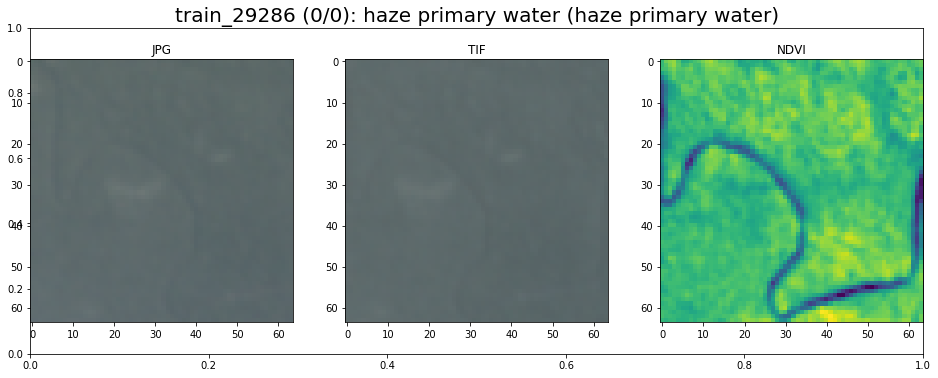

In [91]:
s = good_by_tags.sample(1)
plot_choice(s.iloc[0]['image_name'])


In [54]:
s.loc[s['image_name'] == 'train_22204'].iloc[0]

image_name                       train_22204
warp                                 24.0231
warp_blur                            9.50306
tag_jpgs         partly_cloudy primary water
tag_predicted    partly_cloudy primary water
otags_jpgs       partly_cloudy primary water
otags_tiffs      partly_cloudy primary water
Name: 27022, dtype: object

## Spot checks


/opt/conda/lib/python3.5/site-packages/rasterio/__init__.py:193: UserWarning: Dataset has no geotransform set.  Default transform will be applied (Affine.identity())
  s.start()


(64, 64, 3)
(64, 64, 3)
(64, 64)


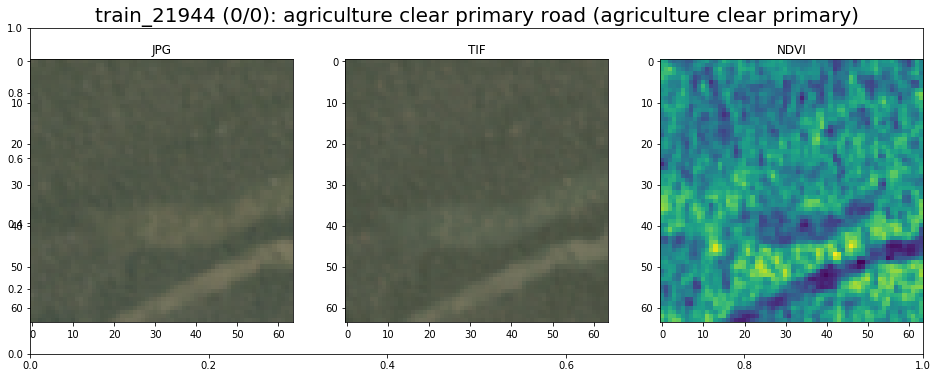

In [112]:
plot_choice(good_apples.sample(1).iloc[0]['image_name'])

/opt/conda/lib/python3.5/site-packages/rasterio/__init__.py:193: UserWarning: Dataset has no geotransform set.  Default transform will be applied (Affine.identity())
  s.start()


(64, 64, 3)
(64, 64, 3)
(64, 64)


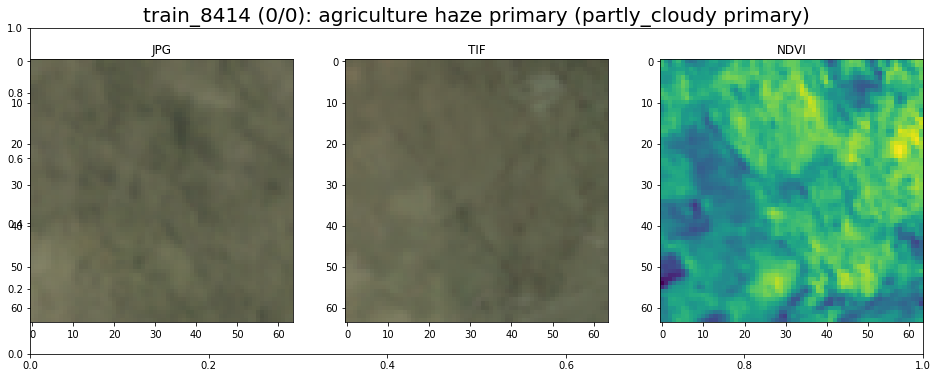

In [117]:
plot_choice(bad_apples.sample(1).iloc[0]['image_name'])

## Working with the image feature csv

In [3]:
p = "/opt/data/datasets/planet_kaggle/image_features_total.csv"
d = pd.read_csv(p)

In [174]:
d[['image_name', 'warp_1',
       'warp_2', 'warp_3', 'warp_4', 'warp_5', 'warp_6', 'warp_7', 'warp_8',
       'warp_9', 'warp_base']]


image_name       warp_1       warp_2       warp_3       warp_4  \
0      train_0     2.105978 -1000.000000 -1000.000000 -1000.000000   
1      train_1     0.024840     0.045541     0.072475     0.111585   
2     train_10     0.078746     0.100051     0.005976     0.080000   
3    train_100     0.231856     0.117580     0.086438     0.377009   
4   train_1000     0.016939     0.032626     0.070097     0.124168   
5  train_10000 -1000.000000     8.441331    17.288629     9.079340   
6  train_10001     3.185828     3.252046     2.293134    13.710453   
7  train_10002     0.049324     0.037561     0.056008     0.148501   
8  train_10003     0.079213     0.028892     0.061930     0.093481   
9  train_10004 -1000.000000 -1000.000000 -1000.000000 -1000.000000   

        warp_5       warp_6       warp_7       warp_8       warp_9  \
0 -1000.000000     1.457709 -1000.000000     7.944661 -1000.000000   
1 -1000.000000     0.056556     0.072475     0.025864     0.072475   
2 -1000.000000     0.039583     0.005976     0.040998     0.005976   
3     5.034242     0.234259     0.086438     0.007290     0.086438   
4 -1000.000000     0.064009     0.070097     0.027395     0.070097   
5 -1000.000000     9.500223    17.288629     1.314989    17.288629   
6 -1000.000000     2.317020     2.293134     1.689121     2.293134   
7 -1000.000000     0.049642     0.056008     0.018577     0.056008   
8 -1000.000000     0.034478     0.061930     0.041543     0.061930   
9 -1000.000000 -1000.000000 -1000.000000 -1000.000000 -1000.000000   

     warp_base  
0     7.977142  
1     0.043533  
2     0.085661  
3     0.033242  
4     0.018178  
5     2.726220  
6     9.678486  
7     0.034386  
8     0.052362  
9 -1000.000000

In [170]:
d.columns

Index(['Unnamed: 0', 'NDVI_0_0_0', 'NDVI_0_1_0', 'NDVI_0_2_0', 'NDVI_0_3_0',
       'NDVI_1_0_0', 'NDVI_1_1_0', 'NDVI_1_2_0', 'NDVI_1_3_0', 'NDVI_2_0_0',
       'NDVI_2_1_0', 'NDVI_2_2_0', 'NDVI_2_3_0', 'NDVI_3_0_0', 'NDVI_3_1_0',
       'NDVI_3_2_0', 'NDVI_3_3_0', 'NDWI_0_0_0', 'NDWI_0_1_0', 'NDWI_0_2_0',
       'NDWI_0_3_0', 'NDWI_1_0_0', 'NDWI_1_1_0', 'NDWI_1_2_0', 'NDWI_1_3_0',
       'NDWI_2_0_0', 'NDWI_2_1_0', 'NDWI_2_2_0', 'NDWI_2_3_0', 'NDWI_3_0_0',
       'NDWI_3_1_0', 'NDWI_3_2_0', 'NDWI_3_3_0', 'image_name', 'warp_1',
       'warp_2', 'warp_3', 'warp_4', 'warp_5', 'warp_6', 'warp_7', 'warp_8',
       'warp_9', 'warp_base'],
      dtype='object')

In [4]:
d.count()

Unnamed: 0        101670
CHLGREEN_0_0_0    101670
CHLGREEN_0_1_0    101670
CHLGREEN_0_2_0    101670
CHLGREEN_0_3_0    101670
CHLGREEN_1_0_0    101670
CHLGREEN_1_1_0    101670
CHLGREEN_1_2_0    101670
CHLGREEN_1_3_0    101670
CHLGREEN_2_0_0    101670
CHLGREEN_2_1_0    101670
CHLGREEN_2_2_0    101670
CHLGREEN_2_3_0    101670
CHLGREEN_3_0_0    101670
CHLGREEN_3_1_0    101670
CHLGREEN_3_2_0    101670
CHLGREEN_3_3_0    101670
FE3+_0_0_0        101670
FE3+_0_1_0        101670
FE3+_0_2_0        101670
FE3+_0_3_0        101670
FE3+_1_0_0        101670
FE3+_1_1_0        101670
FE3+_1_2_0        101670
FE3+_1_3_0        101670
FE3+_2_0_0        101670
FE3+_2_1_0        101670
FE3+_2_2_0        101670
FE3+_2_3_0        101670
FE3+_3_0_0        101670
                   ...  
NDVI_3_0_0        101670
NDVI_3_1_0        101670
NDVI_3_2_0        101670
NDVI_3_3_0        101670
NDWI_0_0_0        101670
NDWI_0_1_0        101670
NDWI_0_2_0        101670
NDWI_0_3_0        101670
NDWI_1_0_0        101670


In [206]:
(3.6 * 100000) / (60 * 60 * 4 * 50)

0.5